In [92]:
# Data
import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Validation
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, SelectFromModel
from scipy import stats
import statsmodels.api as sm

# Others
import joblib
from datetime import datetime
import os
import yfinance as yf
from bs4 import BeautifulSoup
import requests
import re

In [189]:
def download_and_concat_tickers(tickers, start_date=None, end_date=None, interval='1d'):
    """Download data of provided tickers for the specified interval"""
    if start_date:
        df = yf.download(tickers, start=start_date, end=end_date, interval=interval)
    else:
        df = yf.download(tickers, period="max", interval=interval)

    df.columns = [f"{ticker}_{field}" for field, ticker in df.columns]

    return df

tickers = [
    "^GSPC", "^DJI", "^VIX", "^GVZ", "^OVX", "^MOVE", "BOND", "^STOXX",
    "EURUSD=X", "DX-Y.NYB", "CL=F", "BZ=F", "SI=F", "PL=F", "BTC-USD", "JPM",
    "PA=F", "^TNX", "GC=F", "GDX", "EGO", "USO", "GD=F",
]

result_df = download_and_concat_tickers(tickers, start_date="2000-08-30", end_date="2025-12-11")
result_df.tail()

/tmp/ipykernel_2669/2686361912.py:4: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  23 of 23 completed


BOND_Close  BTC-USD_Close  BZ=F_Close  CL=F_Close  DX-Y.NYB_Close  \
Date                                                                            
2025-12-06         NaN   89272.375000         NaN         NaN             NaN   
2025-12-07         NaN   90405.640625         NaN         NaN             NaN   
2025-12-08   92.959999   90640.203125   62.490002   58.880001       99.089996   
2025-12-09   92.879997   92691.710938   61.939999   58.250000       99.220001   
2025-12-10   93.199997   92020.945312   62.209999   58.459999       98.790001   

            EGO_Close  EURUSD=X_Close   GC=F_Close  GD=F_Close  GDX_Close  \
Date                                                                        
2025-12-06        NaN             NaN          NaN         NaN        NaN   
2025-12-07        NaN             NaN          NaN         NaN        NaN   
2025-12-08  30.870001        1.164022  4187.200195  556.349976  79.160004   
2025-12-09  32.360001        1.164144  4206.700195  552.299988  81.940002   
2025-12-10  33.570000        1.162831  4196.399902  554.200012  83.320000   

            ...  SI=F_Volume  USO_Volume  ^DJI_Volume  ^GSPC_Volume  \
Date        ...                                                       
2025-12-06  ...          NaN         NaN          NaN           NaN   
2025-12-07  ...          NaN         NaN          NaN           NaN   
2025-12-08  ...        518.0   3073400.0  505490000.0  4.757130e+09   
2025-12-09  ...        324.0   3111300.0  425470000.0  4.508050e+09   
2025-12-10  ...        462.0   8096000.0  545610000.0  5.526570e+09   

            ^GVZ_Volume  ^MOVE_Volume  ^OVX_Volume  ^STOXX_Volume  \
Date                                                                
2025-12-06          NaN           NaN          NaN            NaN   
2025-12-07          NaN           NaN          NaN            NaN   
2025-12-08          0.0           0.0          0.0    159308700.0   
2025-12-09          0.0           0.0          0.0    170040500.0   
2025-12-10          0.0           0.0          0.0    209327200.0   

            ^TNX_Volume  ^VIX_Volume  
Date                                  
2025-12-06          NaN          NaN  
2025-12-07          NaN          NaN  
2025-12-08          0.0          0.0  
2025-12-09          0.0          0.0  
2025-12-10          0.0          0.0  

[5 rows x 115 columns]

In [141]:
# Save csv
#result_df.to_csv("../raw_data/new_data.csv")

                                 Open        High         Low       Close  \
Date                                                                        
2000-08-30 00:00:00-04:00  273.899994  273.899994  273.899994  273.899994   
2000-08-31 00:00:00-04:00  274.799988  278.299988  274.799988  278.299988   
2000-09-01 00:00:00-04:00  277.000000  277.000000  277.000000  277.000000   
2000-09-05 00:00:00-04:00  275.799988  275.799988  275.799988  275.799988   
2000-09-06 00:00:00-04:00  274.200012  274.200012  274.200012  274.200012   

                           Volume  Dividends  Stock Splits  
Date                                                        
2000-08-30 00:00:00-04:00       0        0.0           0.0  
2000-08-31 00:00:00-04:00       0        0.0           0.0  
2000-09-01 00:00:00-04:00       0        0.0           0.0  
2000-09-05 00:00:00-04:00       2        0.0           0.0  
2000-09-06 00:00:00-04:00       0        0.0           0.0  


<Axes: title={'center': 'Gold Price (Daily)'}, xlabel='Date'>

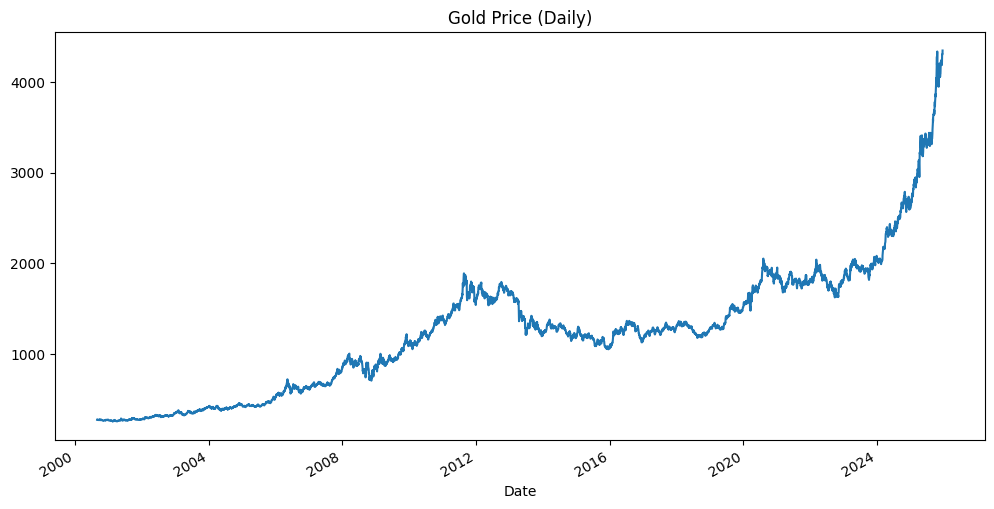

In [23]:
# Get the history of a ticker
gold = yf.Ticker("GC=F")
data = gold.history(period="max", interval="1d")
df_gold = pd.DataFrame(data)
print(df_gold.head())
df_gold["Close"].plot(title="Gold Price (Daily)", figsize=(12, 6))

In [189]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7750 entries, 2000-08-30 to 2025-12-10
Columns: 115 entries, BOND_Close to ^VIX_Volume
dtypes: float64(115)
memory usage: 6.9 MB


In [190]:
result_df.describe()

BOND_Close  BTC-USD_Close   BZ=F_Close   CL=F_Close  DX-Y.NYB_Close  \
count  3466.000000    4103.000000  4571.000000  6348.000000     6384.000000   
mean     79.774140   26535.115870    78.100457    64.705819       92.493261   
std       7.909687   31426.153058    23.820727    24.603556       11.203539   
min      61.905216     178.102997    19.330000   -37.630001       71.330002   
25%      73.665119    2657.754883    61.139999    46.317500       82.510002   
50%      78.926384   10668.968750    75.550003    63.809999       92.920002   
75%      86.427822   41798.712891    97.750000    81.964998       99.589996   
max      93.749237  124752.531250   146.080002   145.289993      120.900002   

         EGO_Close  EURUSD=X_Close   GC=F_Close   GD=F_Close    GDX_Close  \
count  5759.000000     5716.000000  6344.000000  4963.000000  4921.000000   
mean     26.263301        1.225024  1244.762578   517.301858    31.761441   
std      22.465491        0.127433   715.204490   119.185051    11.616030   
min       2.640000        0.959619   255.100006   230.300003    11.390457   
25%      10.835000        1.117197   648.400024   419.779999    21.883282   
50%      17.120001        1.207700  1247.549988   523.549988    30.637808   
75%      33.144144        1.320228  1675.674988   613.399994    38.893036   
max     105.309479        1.598798  4336.399902   886.799988    84.440002   

       ...    SI=F_Volume    USO_Volume   ^DJI_Volume  ^GSPC_Volume  \
count  ...    6346.000000  4.950000e+03  6.358000e+03  6.358000e+03   
mean   ...    1454.914277  3.043679e+06  2.610088e+08  3.479556e+09   
std    ...    8444.161263  4.018552e+06  1.334033e+08  1.480125e+09   
min    ...       0.000000  1.488800e+04  8.410000e+06  0.000000e+00   
25%    ...       5.000000  1.029203e+06  1.707725e+08  2.492902e+09   
50%    ...      36.000000  2.296969e+06  2.469150e+08  3.563250e+09   
75%    ...     142.000000  3.993554e+06  3.244725e+08  4.280720e+09   
max    ...  170297.000000  1.249130e+08  1.412960e+09  1.145623e+10   

       ^GVZ_Volume  ^MOVE_Volume  ^OVX_Volume  ^STOXX_Volume    ^TNX_Volume  \
count       4410.0        5705.0       4678.0   5.442000e+03    6352.000000   
mean           0.0           0.0          0.0   1.295728e+08    1030.588791   
std            0.0           0.0          0.0   1.272028e+08   12659.711272   
min            0.0           0.0          0.0   0.000000e+00       0.000000   
25%            0.0           0.0          0.0   0.000000e+00       0.000000   
50%            0.0           0.0          0.0   1.591713e+08       0.000000   
75%            0.0           0.0          0.0   2.211025e+08       0.000000   
max            0.0           0.0          0.0   1.109144e+09  159700.000000   

       ^VIX_Volume  
count       6358.0  
mean           0.0  
std            0.0  
min            0.0  
25%            0.0  
50%            0.0  
75%            0.0  
max            0.0  

[8 rows x 115 columns]

In [191]:
# NaN check
result_df.isna().sum() / len(result_df) * 100

BOND_Close        55.277419
BTC-USD_Close     47.058065
BZ=F_Close        41.019355
CL=F_Close        18.090323
DX-Y.NYB_Close    17.625806
                    ...    
^MOVE_Volume      26.387097
^OVX_Volume       39.638710
^STOXX_Volume     29.780645
^TNX_Volume       18.038710
^VIX_Volume       17.961290
Length: 115, dtype: float64

In [94]:
def clean_name(name: str):
    s = str(name)

    # 1) remove leading non-alphanumeric characters (anything not [A-Za-z0-9])
    s = re.sub(r'^[^A-Za-z0-9]+', '', s)

    # 2) replace any remaining non-word characters with underscores
    # \w = [A-Za-z0-9_]; anything else becomes '_'
    s = re.sub(r'\W+', '_', s)

    # 3) collapse multiple underscores
    s = re.sub(r'_+', '_', s)

    # 4) strip trailing underscores (optional but tidy)
    s = s.strip('_')

    return s

In [190]:
# --- Preprocessing ---
# Drop NaN based on gold price
result_df = result_df.dropna(how='any', subset=["GC=F_Close"], axis=0)

# Replace special characters in columns name
result_df.columns = [clean_name(c) for c in result_df.columns]

In [125]:
a = result_df.groupby(result_df.index).count().sum(axis=1)
px.line(a)

In [339]:
result_df

VIX_Open   VIX_High    VIX_Low  VIX_Close  DX-Y.NYB_Open  \
Date                                                                    
2012-01-26  17.959999  19.170000  16.799999  18.570000      79.489998   
2012-01-27  19.160000  19.160000  18.260000  18.530001      79.449997   
2012-01-30  20.330000  20.330000  19.379999  19.400000      78.900002   
2012-01-31  19.070000  19.840000  18.129999  19.440001      79.099998   
2012-02-01  18.680000  18.820000  17.990000  18.549999      79.309998   
...               ...        ...        ...        ...            ...   
2025-12-04  16.230000  16.629999  15.680000  15.780000      98.919998   
2025-12-05  15.580000  16.180000  15.280000  15.410000      99.040001   
2025-12-08  16.150000  17.090000  16.100000  16.660000      98.970001   
2025-12-09  16.660000  17.200001  16.450001  16.930000      99.050003   
2025-12-10  16.940001  17.660000  15.560000  15.770000      99.220001   

            DX-Y.NYB_High  DX-Y.NYB_Low  DX-Y.NYB_Close    PA_F_Open  \
Date                                                                   
2012-01-26      79.540001     79.059998       79.410004   693.900024   
2012-01-27      79.540001     78.769997       78.900002   689.599976   
2012-01-30      79.449997     78.769997       79.160004   688.099976   
2012-01-31      79.480003     78.739998       79.279999   685.950012   
2012-02-01      79.570000     78.620003       78.919998   696.299988   
...                   ...           ...             ...          ...   
2025-12-04      99.080002     98.769997       98.989998  1449.500000   
2025-12-05      99.129997     98.809998       98.989998  1472.000000   
2025-12-08      99.230003     98.790001       99.089996  1495.500000   
2025-12-09      99.309998     98.949997       99.220001  1511.400024   
2025-12-10      99.260002     98.589996       98.790001  1458.300049   

              PA_F_High  ...  GDX_Close  GDX_Volume    GSPC_Open    GSPC_High  \
Date                     ...                                                    
2012-01-26   693.900024  ...  49.194874  20174200.0  1326.280029  1333.469971   
2012-01-27   689.599976  ...  50.412399  14823200.0  1318.250000  1320.060059   
2012-01-30   688.099976  ...  49.812462   8660600.0  1316.160034  1316.160034   
2012-01-31   685.950012  ...  49.812462  14442300.0  1313.530029  1321.410034   
2012-02-01   696.299988  ...  49.900681   8178400.0  1312.449951  1330.520020   
...                 ...  ...        ...         ...          ...          ...   
2025-12-04  1451.900024  ...  81.389999  12264600.0  6866.470215  6866.470215   
2025-12-05  1479.000000  ...  81.029999  17559200.0  6866.319824  6895.779785   
2025-12-08  1500.000000  ...  79.160004  18977000.0  6875.200195  6878.270020   
2025-12-09  1511.400024  ...  81.940002  19287000.0  6840.609863  6864.919922   
2025-12-10  1458.300049  ...  83.320000  22917900.0  6833.490234  6900.669922   

               GSPC_Low   GSPC_Close  EURUSD_X_Open  EURUSD_X_High  \
Date                                                                 
2012-01-26  1313.599976  1318.430054       1.310736       1.317992   
2012-01-27  1311.719971  1316.329956       1.308918       1.315997   
2012-01-30  1300.489990  1313.010010       1.320655       1.320847   
2012-01-31  1306.689941  1312.410034       1.313888       1.321353   
2012-02-01  1312.449951  1324.089966       1.313888       1.321353   
...                 ...          ...            ...            ...   
2025-12-04  6827.120117  6857.120117       1.166671       1.168224   
2025-12-05  6858.290039  6870.399902       1.164456       1.167147   
2025-12-08  6827.189941  6846.509766       1.164117       1.167256   
2025-12-09  6837.430176  6840.509766       1.164144       1.165678   
2025-12-10  6824.689941  6886.680176       1.162845       1.165746   

            EURUSD_X_Low  EURUSD_X_Close  
Date                                      
2012-01-26      1.309483        1.310736  
2012-01-27      0.760572        

In [96]:
def chronological_split(X, y, train_ratio=0.7):
    """Chronological split (no shuffle). Returns X_train, X_val, y_train, y_val."""
    X = X.sort_index()
    y = y.loc[X.index]
    split_idx = int(np.floor(len(X) * train_ratio))
    return X.iloc[:split_idx], X.iloc[split_idx:], y.iloc[:split_idx], y.iloc[split_idx:]

def evaluate_metrics(y_true, y_pred, prefix=""):
    """Compute MAE, RMSE, R2 and print them."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix} MAE={mae:.6f} | RMSE={rmse:.6f} | R2={r2:.6f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def learning_curves_time_series(estimator, X, y, train_sizes, n_splits=5, scoring='rmse'):
    """
    Time-series learning curves: for increasing train sizes, use TimeSeriesSplit folds.
    Returns arrays of avg train and validation scores.
    """
    train_scores = []
    val_scores = []

    for ts in train_sizes:
        X_sub = X.iloc[:ts]
        y_sub = y.iloc[:ts]

        tscv = TimeSeriesSplit(n_splits=n_splits)
        fold_train_scores, fold_val_scores = [], []

        for tr_idx, va_idx in tscv.split(X_sub):
            X_tr, X_va = X_sub.iloc[tr_idx], X_sub.iloc[va_idx]
            y_tr, y_va = y_sub.iloc[tr_idx], y_sub.iloc[va_idx]

            est = clone(estimator)
            est.fit(X_tr, y_tr)

            y_tr_pred = est.predict(X_tr)
            y_va_pred = est.predict(X_va)

            y_tr_pred = X_tr["GC_F_Close"] * (1 + y_tr_pred)
            y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)
            y_tr = X_tr["GC_F_Close"] * (1 + y_tr)
            y_va = X_va["GC_F_Close"] * (1 + y_va)

            if scoring == 'rmse':
                tr = root_mean_squared_error(y_tr, y_tr_pred)
                va = root_mean_squared_error(y_va, y_va_pred)
            elif scoring == 'mae':
                tr = mean_absolute_error(y_tr, y_tr_pred)
                va = mean_absolute_error(y_va, y_va_pred)
            elif scoring == 'r2':
                tr = r2_score(y_tr, y_tr_pred)
                va = r2_score(y_va, y_va_pred)
            else:
                raise ValueError("Unsupported scoring")

            fold_train_scores.append(tr)
            fold_val_scores.append(va)

        train_scores.append(np.mean(fold_train_scores))
        val_scores.append(np.mean(fold_val_scores))

    return np.array(train_scores), np.array(val_scores)


In [97]:
class PrePreprocessTransformer(BaseEstimator, TransformerMixin):
    """
    Drop columns mostly fill of 0
    """
    def __init__(self, threshold=0.9, exclude=None):
        self.threshold = threshold
        self.exclude = exclude or []
        self._drop_cols_ = None  # learned set of columns to drop
        self._feature_names_in_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("PrePreprocessTransformer expects a pandas DataFrame in fit.")

        self._feature_names_in_ = X.columns.tolist()

        # Work on a copy to avoid mutation
        df = X.copy()

        # Restrict to numeric columns (excluding any explicitly protected ones)
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        num_cols = [c for c in num_cols if c not in self.exclude]

        # Compute zero ratio per column using non-NA counts
        zero_ratio = (df[num_cols] == 0).sum() / df[num_cols].count()

        # Columns to drop, learned from training data
        self._drop_cols_ = zero_ratio[zero_ratio >= self.threshold].index.tolist()
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("PrePreprocessTransformer expects a pandas DataFrame in transform.")

        if self._drop_cols_ is None:
            raise RuntimeError("Transformer not fitted. Call fit before transform.")

        # Drop the learned columns (ignore missing ones gracefully)
        return X.drop(columns=[c for c in self._drop_cols_ if c in X.columns], axis=1)

    def get_feature_names_out(self, input_features=None):
        if self._feature_names_in_ is None:
            raise RuntimeError("Transformer not fitted. Call fit before get_feature_names_out.")
        output = [c for c in self._feature_names_in_ if c not in (self._drop_cols_ or [])]
        return np.array(output, dtype=object)

    def set_output(self, *, transform=None):
        # compatibility with sklearn's set_output API
        return self


class CustomPreprocessTransformer(BaseEstimator, TransformerMixin):
    """
     Fill NaN based on a custom strategy:
    - if gap at the begining, fill with the first known value
    - if gap in the middle, linear interpolation
    - if gap at the end, fill with the last known value
    """
    def __init__(self, method='linear', drop_all_nan=False):
        self.method = method
        self.drop_all_nan = drop_all_nan
        self._feature_names_in_ = None
        self._feature_names_out_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("PreprocessEngineeringTransformer expects a pandas DataFrame in fit.")

        self._feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("PreprocessEngineeringTransformer expects a pandas DataFrame.")

        X = X.copy()

        # Select the columns
        numeric_cols = X.select_dtypes(include=[np.number]).columns

        # Fill NaN strategy
        X[numeric_cols] = (
            X[numeric_cols].interpolate(method=self.method, axis=0, limit_direction="both")
        )

        # Drop columns of full NaN
        if self.drop_all_nan:
            all_nan_cols = [c for c in numeric_cols if X[c].isna().all()]
            if all_nan_cols:
                X = X.drop(columns=all_nan_cols)

        # Track output feature names post-transform
        self._feature_names_out_ = X.columns.to_list()

        return X

    def get_feature_names_out(self, input_features=None):
        if self._feature_names_out_ is not None:
            return np.array(self._feature_names_out_, dtype=object)

        if self._feature_names_in_ is not None:
            return np.array(self._feature_names_in_, dtype=object)
        raise RuntimeError("Transformer not fitted. Call fit/transform before get_feature_names_out.")

    def set_output(self, *, transform=None):
        # No-op to be compatible with pipelines calling set_output
        return self


class CustomFeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._feature_names_in_ = None
        self._feature_names_out_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("CustomFeatureEngineeringTransformer expects a pandas DataFrame")

        self._feature_names_in_ = X.columns.tolist()
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("CustomFeatureEngineeringTransformer expects a pandas DataFrame")

        df = X.copy()

        # Drop ohl columns
        drop_cols = [c for c in df.columns if c.endswith("_Open") or c.endswith("_High") or c.endswith("_Low")]
        df = df.drop(columns=drop_cols, axis=1, errors="ignore")

        # Track output cols
        self._feature_names_out_ = df.columns.tolist()

        return df

    def get_feature_names_out(self, input_features=None):
        return np.array(self._feature_names_out_, dtype=object)

    def set_output(self, *, transform=None):
        # No-op to be compatible with pipelines calling set_output
        return self


class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Drop highly correlated numerical features (> threshold) based on upper triangle of correlation matrix.
    """
    def __init__(self, num_corr_threshold=0.95, method='pearson'):
        self.num_corr_threshold = num_corr_threshold
        self.method = method
        self.num_cols_ = None
        self.num_col_to_drop_ = None
        self._feature_names_in_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("CustomFeatureSelector expects a pandas DataFrame.")
        self._feature_names_in_ = list(X.columns)
        self.num_cols_ = list(X.select_dtypes(include=[np.number]).columns)
        if len(self.num_cols_) == 0:
            self.num_col_to_drop_ = []
            return self
        corr_num = X[self.num_cols_].corr(method=self.method)
        upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(bool)).abs()
        self.num_col_to_drop_ = [c for c in upper.columns if any(upper[c] > self.num_corr_threshold)]
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("CustomFeatureSelector expects a pandas DataFrame.")
        return X.drop(columns=getattr(self, 'num_col_to_drop_', []), errors='ignore')

    def get_feature_names_out(self, input_features=None):
        if self._feature_names_in_ is None:
            raise RuntimeError("Transformer not fitted. Call fit before get_feature_names_out.")
        drop = set(self.num_col_to_drop_ or [])
        output = [c for c in self._feature_names_in_ if c not in drop]
        return np.array(output, dtype=object)

    def set_output(self, *, transform=None):
        # No-op to be compatible with pipelines calling set_output
        return self

In [191]:
def build_preprocessing_pipeline(
    num_corr_threshold=0.95,
    method='linear',
    remove_features=False,
    strategy="custom",
    exclude_for_zero_drop=None
):
    exclude_for_zero_drop = exclude_for_zero_drop or []
    num_selector = make_column_selector(dtype_include=np.number)
    excluded = ["GC_ret_sign", "GC_sign_streak"]

    def num_except_excluded(X: pd.DataFrame):
        numeric_cols = num_selector(X)
        return [c for c in numeric_cols if c not in excluded]

    #cat_selector = make_column_selector(dtype_include=["object", "category"])

    if strategy == "custom":
        pre_steps = Pipeline([
            ("preprocess", PrePreprocessTransformer(exclude=exclude_for_zero_drop)),
            ("imputer", CustomPreprocessTransformer(method=method)),
            ("feature", CustomFeatureEngineeringTransformer()),
        ]).set_output(transform="pandas")

        numeric_block = Pipeline([
            ("scaler", RobustScaler())
        ])

        preprocessor = Pipeline([
            ("pre_custom", pre_steps),
            ("ct", ColumnTransformer(
                transformers=[("num", numeric_block, num_except_excluded),
                              ("pass", "passthrough", excluded),
                              #("cat", OrdinalEncoder(handle_unknown="ignore"), cat_selector),
                              ],
                remainder="drop"
            ).set_output(transform="pandas"))
        ]).set_output(transform="pandas")

    else:
        raise TypeError("Strategy not correct")

    if remove_features:
        pipe_new = Pipeline(steps=[
            ("preprocessing", preprocessor),
            ("corr_feature_dropper", CustomFeatureSelector(num_corr_threshold=num_corr_threshold, method='pearson')),
        ]).set_output(transform="pandas")
    else:
        pipe_new = Pipeline(steps=[
            ("preprocessing", preprocessor),
        ]).set_output(transform="pandas")

    return pipe_new

In [150]:
# --- Settings ---
horizon_day=1
train_ratio=0.8
num_corr_threshold=0.95
plot_learning_curves=True
strategy="custom"

target_source_col = 'GC_F_Close'

In [192]:
# --- Features creation ---
df = result_df.sort_index().copy()
target_col = f"{target_source_col}_ret_t+{horizon_day}"
df[target_col] = df[target_source_col].pct_change().shift(-horizon_day)

price_cols = [
            'VIX_Close', 'DX_Y_NYB_Close', 'PA_F_Close', 'BZ_F_Close', 'OVX_Close',
            'USO_Close', 'CL_F_Close', 'PL_F_Close', 'TNX_Close', 'GVZ_Close',
            'MOVE_Close', 'GC_F_Close', 'EGO_Close', 'SI_F_Close', 'DJI_Close',
            'GDX_Close', 'GSPC_Close', 'EURUSD_X_Close', 'BOND_Close', 'STOXX_Close',
            'BTC_USD_Close', 'JPM_Close', 'GD_F_Close']

volume_cols = [
            'USO_Volume', 'EGO_Volume', 'GDX_Volume',
            'JPM_Volume', 'BTC_USD_Volume', 'BOND_Volume'
        ]

lags = [1, 2, 3, 5]
windows = [5, 10, 20]

# RETURNS
for col in price_cols:
    if col in df:
        df[col + "_ret"] = df[col].pct_change()

# LAGS
for col in price_cols:
    if col + "_ret" in df:
        for lag in lags:
            df[f"{col}_ret_lag{lag}"] = df[col + "_ret"].shift(lag)

for lag in lags:
    df[f"GC_close_lag{lag}"] = df["GC_F_Close"].shift(lag)

# ROLLING STATS
for col in price_cols:
    ret = df[col + "_ret"]
    for w in windows:
        df[f"{col}_vol_{w}"] = ret.rolling(w).std()
        df[f"{col}_mom_{w}"] = ret.rolling(w).mean()


# SPREADS & RATIOS
df["gold_silver"] = df["GC_F_Close"] / df["SI_F_Close"]
df["gold_oil"] = df["GC_F_Close"] / df["CL_F_Close"]
df["gold_dxy"] = df["GC_F_Close"] / df["DX_Y_NYB_Close"]
df["gold_spx"] = df["GC_F_Close"] / df["GSPC_Close"]
df["gold_vix"] = df["GC_F_Close"] / df["VIX_Close"]
df["gold_rate"] = df["GC_F_Close"] / df["TNX_Close"]

spread_cols = [
    "gold_silver", "gold_oil", "gold_dxy", "gold_spx", "gold_vix", "gold_rate"
]

for col in spread_cols:
    df[col + "_ret"] = df[col].pct_change()
    for lag in lags:
        df[f"{col}_ret_lag{lag}"] = df[col + "_ret"].shift(lag)
    for w in windows:
        df[f"{col}_vol_{w}"] = df[col + "_ret"].rolling(w).std()
        df[f"{col}_mom_{w}"] = df[col + "_ret"].rolling(w).mean()

# VOLUMES
for col in volume_cols:
    df[col + "_ret"] = df[col].pct_change()
    df[col + "_zscore"] = (df[col] - df[col].rolling(20).mean()) / df[col].rolling(20).std()
    for w in windows:
        df[f"{col}_mom_{w}"] = df[col + "_ret"].rolling(w).mean()

# CROSS-ASSET INTERACTIONS
df["gold_vix_interact"] = df["GC_F_Close_ret"] * df["VIX_Close_ret"]
df["gold_dxy_interact"] = df["GC_F_Close_ret"] * df["DX_Y_NYB_Close_ret"]
df["gold_oil_interact"] = df["GC_F_Close_ret"] * df["CL_F_Close_ret"]
df["gold_spx_interact"] = df["GC_F_Close_ret"] * df["GSPC_Close_ret"]

# GOLD SPECIFIC FEATURES
df["GC_range"] = df["GC_F_High"] - df["GC_F_Low"]
df["GC_range_pct"] = df["GC_range"] / df["GC_F_Close"]
df["GC_true_range"] = np.maximum(df["GC_range"],
   np.maximum(
       abs(df["GC_F_High"] - df["GC_F_Close"].shift(1)),
       abs(df["GC_F_Low"] - df["GC_F_Close"].shift(1))
   )
)
df["GC_intraday_return"] = (df["GC_F_Close"] - df["GC_F_Open"]) / df["GC_F_Open"]
df["GC_ret_sign"] = np.sign(df["GC_F_Close_ret"])
df["GC_diff"] = df["GC_F_Close"].diff()
grp = (df["GC_ret_sign"] != df["GC_ret_sign"].shift()).cumsum()
df["GC_sign_streak"] = df["GC_ret_sign"].groupby(grp).cumcount() + 1


/tmp/ipykernel_2669/1113605047.py:24: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/tmp/ipykernel_2669/1113605047.py:24: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/tmp/ipykernel_2669/1113605047.py:24: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/tmp/ipykernel_2669/1113605047.py:24: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future 

In [193]:
# Drop values of the shift
df = df.dropna(subset=[target_col])

# Set close column as first column
cols = list(df.columns)
cols.remove(target_source_col)
cols.insert(0, target_source_col)
df = df[cols]
df.head()

GC_F_Close  BOND_Close  BTC_USD_Close  BZ_F_Close  CL_F_Close  \
Date                                                                        
2000-08-30  273.899994         NaN            NaN         NaN   33.400002   
2000-08-31  278.299988         NaN            NaN         NaN   33.099998   
2000-09-01  277.000000         NaN            NaN         NaN   33.380001   
2000-09-05  275.799988         NaN            NaN         NaN   33.799999   
2000-09-06  274.200012         NaN            NaN         NaN   34.950001   

            DX_Y_NYB_Close  EGO_Close  EURUSD_X_Close  GD_F_Close  GDX_Close  \
Date                                                                           
2000-08-30      112.139999        NaN             NaN         NaN        NaN   
2000-08-31      112.599998        NaN             NaN         NaN        NaN   
2000-09-01      111.419998        NaN             NaN         NaN        NaN   
2000-09-05      112.410004        NaN             NaN         NaN        NaN   
2000-09-06      114.120003        NaN             NaN         NaN        NaN   

            ...  gold_dxy_interact  gold_oil_interact  gold_spx_interact  \
Date        ...                                                            
2000-08-30  ...                NaN                NaN                NaN   
2000-08-31  ...           0.000066          -0.000144           0.000161   
2000-09-01  ...           0.000049          -0.000040          -0.000010   
2000-09-05  ...          -0.000038          -0.000055           0.000039   
2000-09-06  ...          -0.000088          -0.000197           0.000057   

            GC_range  GC_range_pct  GC_true_range  GC_intraday_return  \
Date                                                                    
2000-08-30       0.0      0.000000            NaN            0.000000   
2000-08-31       3.5      0.012576       4.399994            0.012737   
2000-09-01       0.0      0.000000       1.299988            0.000000   
2000-09-05       0.0      0.000000       1.200012            0.000000   
2000-09-06       0.0      0.000000       1.599976            0.000000   

            GC_ret_sign   GC_diff  GC_sign_streak  
Date                                               
2000-08-30          NaN       NaN               1  
2000-08-31          1.0  4.399994               1  
2000-09-01         -1.0 -1.299988               1  
2000-09-05         -1.0 -1.200012               2  
2000-09-06         -1.0 -1.599976               3  

[5 rows x 486 columns]

In [194]:
# --- Features and target ---
feature_cols = df.drop(columns=target_col).columns
X = df[feature_cols]
y = df[target_col]

In [195]:
# --- Split ---
X_train, X_val, y_train, y_val = chronological_split(X, y, train_ratio)

In [196]:
# --- Preprocessing pipeline ---
pipe_new = build_preprocessing_pipeline(strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])
pipe_new

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('pre_custom',
                                  Pipeline(steps=[('preprocess',
                                                   PrePreprocessTransformer(exclude=['GC_F_Close'])),
                                                  ('imputer',
                                                   CustomPreprocessTransformer()),
                                                  ('feature',
                                                   CustomFeatureEngineeringTransformer())])),
                                 ('ct',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    RobustScaler())]),
                                                                   <function build_preprocessing_pipeline.<locals>.num_except_excluded at 0x7ace547a76d0>),
                                                                  ('pass',
                                                                   'passthrough',
                                                                   ['GC_ret_sign',
                                                                    'GC_sign_streak'])]))]))])

In [197]:
# --- Fit preprocessing ---
X_train_proc = pipe_new.fit_transform(X_train, y_train)
X_val_proc = pipe_new.transform(X_val)

In [133]:
display(X_train_proc, X_val_proc)

num__GC_F_Close  num__BOND_Close  num__BTC_USD_Close  \
Date                                                               
2000-08-30        -1.029010         0.000000            0.000000   
2000-08-31        -1.023858         0.000000            0.000000   
2000-09-01        -1.025380         0.000000            0.000000   
2000-09-05        -1.026785         0.000000            0.000000   
2000-09-06        -1.028658         0.000000            0.000000   
...                     ...              ...                 ...   
2020-11-16         0.860162         2.470813        16258.777313   
2020-11-17         0.856884         2.473518        17188.072235   
2020-11-18         0.844003         2.481633        17346.671844   
2020-11-19         0.829484         2.499210        17359.755829   
2020-11-20         0.842950         2.503265        18163.980438   

            num__BZ_F_Close  num__CL_F_Close  num__DX_Y_NYB_Close  \
Date                                                                
2000-08-30         0.000000        -0.618126             1.448136   
2000-08-31         0.000000        -0.625499             1.476837   
2000-09-01         0.000000        -0.618618             1.403213   
2000-09-05         0.000000        -0.608295             1.464982   
2000-09-06         0.000000        -0.580031             1.571674   
...                     ...              ...                  ...   
2020-11-16        -1.565953        -0.422980             0.227110   
2020-11-17        -1.569387        -0.420768             0.217751   
2020-11-18        -1.540443        -0.411183             0.211511   
2020-11-19        -1.547311        -0.413149             0.209640   
2020-11-20        -1.510026        -0.403072             0.215879   

            num__EGO_Close  num__EURUSD_X_Close  num__GD_F_Close  \
Date                                                               
2000-08-30       -0.419154            -0.176034         0.000000   
2000-08-31       -0.419154            -0.176034         0.000000   
2000-09-01       -0.419154            -0.176034         0.000000   
2000-09-05       -0.419154            -0.176034         0.000000   
2000-09-06       -0.419154            -0.176034         0.000000   
...                    ...                  ...              ...   
2020-11-16       -0.191972            -0.253980        -0.560925   
2020-11-17       -0.200662            -0.244745        -0.527702   
2020-11-18       -0.218043            -0.241998        -0.512418   
2020-11-19       -0.221664            -0.252427        -0.528507   
2020-11-20       -0.218767            -0.240166        -0.502363   

            num__GDX_Close  ...  num__gold_dxy_interact  \
Date                        ...                           
2000-08-30        0.000000  ...                2.353106   
2000-08-31        0.000000  ...                2.353106   
2000-09-01        0.000000  ...                1.790354   
2000-09-05        0.000000  ...               -1.113958   
2000-09-06        0.000000  ...               -2.766514   
...                    ...  ...                     ...   
2020-11-16        0.278650  ...                0.106782   
2020-11-17        0.217246  ...                0.244356   
2020-11-18        0.133377  ...                0.374274   
2020-11-19        0.110911  ...                0.235940   
2020-11-20        0.139367  ...                0.386879   

            num__gold_oil_interact  num__gold_spx_interact  num__GC_range  \
Date                                                                        
2000-08-30               -1.221199                3.354255      -0.558823   
2000-08-31               -1.221199                3.354255      -0.301469   
2000-09-01               -0.377749               -0.197735      -0.558823   
2000-09-05               -0.498451                0.810835      -0.558823   
2000-09-06               -1.648559                1.186882      -0.558823   
...                            ...   

num__GC_F_Close  num__BOND_Close  num__BTC_USD_Close  \
Date                                                               
2020-11-23         0.802201         2.505969        17906.787079   
2020-11-24         0.763561         2.493125        18650.130829   
2020-11-25         0.764615         2.493125        18274.787079   
2020-11-27         0.736747         2.501236        16651.068329   
2020-11-30         0.729487         2.506650        19168.501923   
...                     ...              ...                 ...   
2025-12-03         3.567343         2.609396        93070.470673   
2025-12-04         3.581979         2.594530        91684.290985   
2025-12-05         3.583267         2.586271        88930.423798   
2025-12-08         3.553175         2.564798        90182.869110   
2025-12-09         3.576008         2.558190        92234.376923   

            num__BZ_F_Close  num__CL_F_Close  num__DX_Y_NYB_Close  \
Date                                                                
2020-11-23        -1.456062        -0.380707             0.223366   
2020-11-24        -1.367756        -0.335238             0.205896   
2020-11-25        -1.330962        -0.315576             0.190922   
2020-11-27        -1.352057        -0.320000             0.178443   
2020-11-30        -1.381002        -0.324670             0.183435   
...                     ...              ...                  ...   
2025-12-03        -0.641197         0.009831             0.618936   
2025-12-04        -0.612252         0.027527             0.627671   
2025-12-05        -0.588214         0.037604             0.627671   
2025-12-08        -0.650027         0.008111             0.633910   
2025-12-09        -0.677010        -0.007373             0.642022   

            num__EGO_Close  num__EURUSD_X_Close  num__GD_F_Close  \
Date                                                               
2020-11-23       -0.240493            -0.240166        -0.472197   
2020-11-24       -0.249546            -0.255623        -0.403419   
2020-11-25       -0.248097            -0.218015        -0.394972   
2020-11-27       -0.249546            -0.207936        -0.390950   
2020-11-30       -0.255339            -0.171838        -0.403419   
...                    ...                  ...              ...   
2025-12-03        0.430838            -0.395439         0.970940   
2025-12-04        0.450392            -0.370099         1.000704   
2025-12-05        0.443512            -0.385746         1.037707   
2025-12-08        0.435184            -0.387422         0.968124   
2025-12-09        0.489136            -0.386629         0.935545   

            num__GDX_Close  ...  num__gold_dxy_interact  \
Date                        ...                           
2020-11-23        0.024046  ...               -0.637185   
2020-11-24       -0.046344  ...                1.969573   
2020-11-25        0.000083  ...                0.121414   
2020-11-27        0.014311  ...                1.116258   
2020-11-30        0.048009  ...                0.063787   
...                    ...  ...                     ...   
2025-12-03        3.943589  ...               -0.352623   
2025-12-04        3.970021  ...                0.304530   
2025-12-05        3.941186  ...                0.164509   
2025-12-08        3.791408  ...               -0.040163   
2025-12-09        4.014073  ...                0.367441   

            num__gold_oil_interact  num__gold_spx_interact  num__GC_range  \
Date                                                                        
2020-11-23               -3.289442               -2.177628       0.073539   
2020-11-24               -6.269918               -6.033739       1.647064   
2020-11-25                0.011847               -0.016426      -0.242651   
2020-11-27                0.358166               -0.656869       2.845599   
2020-11-30                0.057233                0.332457       1.272056   
...                            ...   

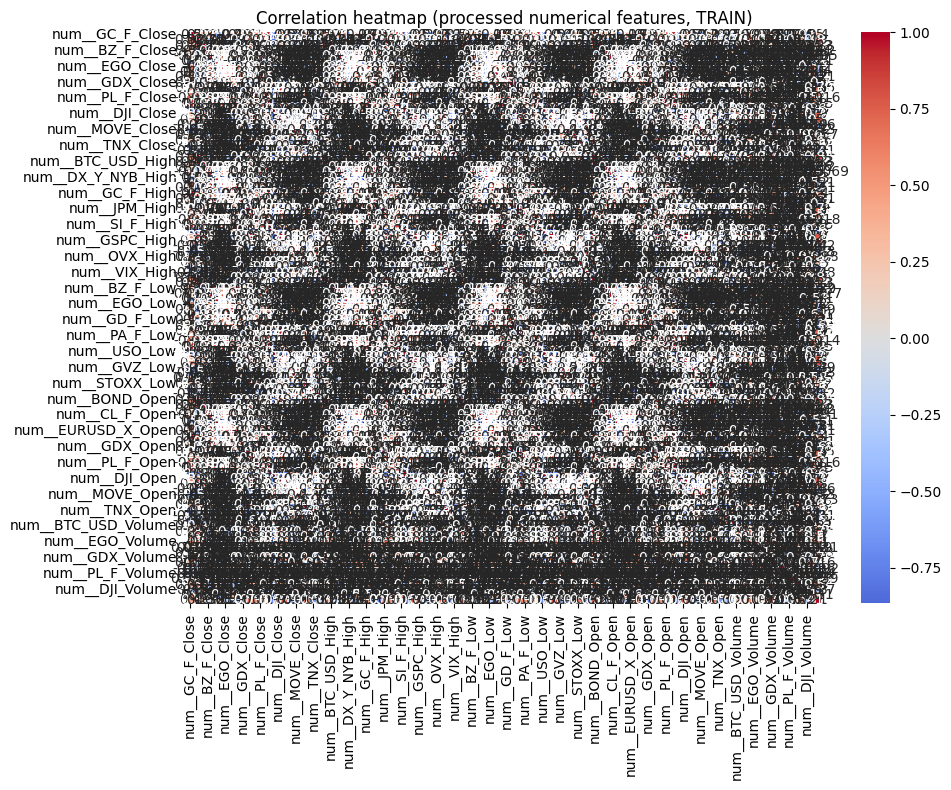

In [159]:
# --- Correlation check ---
processed_feature_names = X_train_proc.columns
num_names = [n for n in processed_feature_names if n.startswith('num__')]
num_idx = [list(processed_feature_names).index(n) for n in num_names]
X_train_num_df = pd.DataFrame(X_train_proc.iloc[:, num_idx], index=X_train.index, columns=num_names)

plt.figure(figsize=(10, 8))
sns.heatmap(X_train_num_df.corr(), cmap='coolwarm', center=0, annot=True)
plt.title('Correlation heatmap (processed numerical features, TRAIN)')
plt.tight_layout(); plt.show()

In [198]:
# --- Automatic clean pipe ---
pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])
pipe_auto

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('pre_custom',
                                  Pipeline(steps=[('preprocess',
                                                   PrePreprocessTransformer(exclude=['GC_F_Close'])),
                                                  ('imputer',
                                                   CustomPreprocessTransformer()),
                                                  ('feature',
                                                   CustomFeatureEngineeringTransformer())])),
                                 ('ct',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    RobustScaler())]),
                                                                   <function build_preprocessing_pipeline.<locals>.num_except_excluded at 0x7acf4421cc10>),
                                                                  ('pass',
                                                                   'passthrough',
                                                                   ['GC_ret_sign',
                                                                    'GC_sign_streak'])]))])),
                ('corr_feature_dropper', CustomFeatureSelector())])

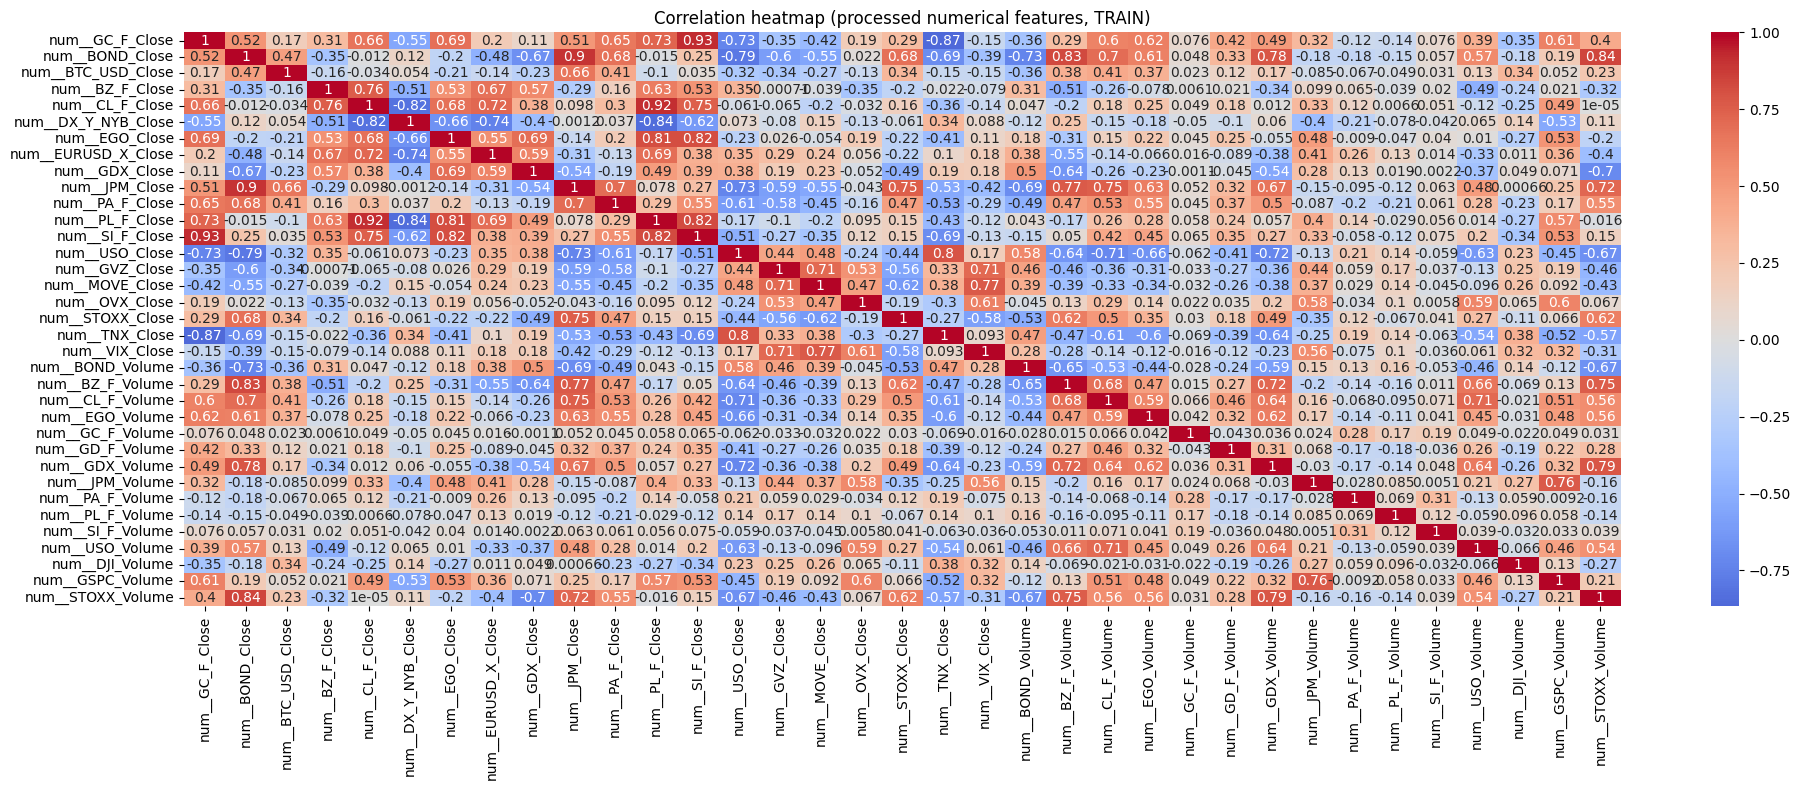

In [161]:
# --- Correlation check of preproc ---
X_train_proc = pipe_auto.fit_transform(X_train, y_train)

plt.figure(figsize=(20, 8))
sns.heatmap(X_train_proc.corr(), cmap='coolwarm', center=0, annot=True)
plt.title('Correlation heatmap (processed numerical features, TRAIN)')
plt.tight_layout(); plt.show()

In [20]:
# List of dropped columns from the selector (pre-drop raw names)
dropper = pipe_auto.named_steps['corr_feature_dropper']
print("Correlated numeric features dropped by selector:", getattr(dropper, 'num_col_to_drop_', []))

Correlated numeric features dropped by selector: None


In [199]:
# --- Final model pipeline ---
model = LinearRegression()

pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
])
pipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('pre_custom',
                                                   Pipeline(steps=[('preprocess',
                                                                    PrePreprocessTransformer(exclude=['GC_F_Close'])),
                                                                   ('imputer',
                                                                    CustomPreprocessTransformer()),
                                                                   ('feature',
                                                                    CustomFeatureEngineeringTransformer())])),
                                                  ('ct',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    Pipeline(steps=[('scaler',
                                                                                                     RobustScaler())]),
                                                                                    <function build_preprocessing_pipeline.<locals>.num_except_excluded at 0x7ace547a7010>),
                                                                                   ('pass',
                                                                                    'passthrough',
                                                                                    ['GC_ret_sign',
                                                                                     'GC_sign_streak'])]))])),
                                 ('corr_feature_dropper',
                                  CustomFeatureSelector())])),
                ('model', LinearRegression())])

In [ ]:
# --- Feature selection ---
model = LinearRegression()

pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('sfm', SelectFromModel(model)),
    ('model', model)
])

if strategy == "custom":
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train = X_train[num_cols].interpolate(method="linear", axis=0, limit_direction="both")

# Cross validate
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []

for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)

    y_va = X_va["GC_F_Close"] * (1 + y_va)
    y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)

    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

Global CV fold 1 MAE=4.386119 | RMSE=6.299004 | R2=0.996229
Global CV fold 2 MAE=9.700994 | RMSE=13.219829 | R2=0.994076
Global CV fold 3 MAE=13.311109 | RMSE=19.148117 | R2=0.987504
Global CV fold 4 MAE=8.070760 | RMSE=11.138602 | R2=0.976056
Global CV fold 5 MAE=9.474898 | RMSE=14.738035 | R2=0.995679
Global CV avg: MAE=8.988776 | RMSE=12.908717 | R2=0.989909


In [487]:
# Get the feature names and importances
model = LinearRegression()

pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('sfm', SelectFromModel(model)),
    ('model', model)
])

pipe.fit(X_train, y_train)

# Get the importances
final_estimator = pipe.named_steps['model']

try:
    coefs = getattr(final_estimator, "coef_", None)
    coefs.ravel()
except AttributeError:
    importance_scores = getattr(final_estimator, "feature_importances_", None)

# Get the names
preproc = pipe.named_steps['preprocessing']
Xt_names_ct = preproc.get_feature_names_out()

# if 'corr_feature_dropper' in pipe.named_steps:
#     selector = pipe.named_steps['corr_feature_dropper']
#     final_names = selector.get_feature_names_out(Xt_names_ct)

# Get selected feature names
sfm = pipe.named_steps['sfm']
selected_mask = sfm.get_support()
selected_names = np.array(Xt_names_ct)[selected_mask]

# DataFrame summary
if coefs is not None:
    df_importances = pd.DataFrame({
        "feature": selected_names,
        "importance": coefs
    }).sort_values("importance", ascending=False).reset_index(drop=True)
else:
    df_importances = pd.DataFrame({
        "feature": selected_names,
        "importance": importance_scores
    }).sort_values("importance", ascending=False).reset_index(drop=True)
df_importances


feature  importance
0   num__BTC_USD_Close_vol_20    0.011794
1   num__BTC_USD_Close_vol_10    0.011788
2         num__GC_F_Close_ret    0.007302
3    num__SI_F_Close_ret_lag3    0.007065
4    num__SI_F_Close_ret_lag1    0.006504
..                        ...         ...
81            num__GC_F_Close   -0.007280
82             num__USO_Close   -0.007619
83       num__gold_silver_ret   -0.007719
84      num__SI_F_Close_mom_5   -0.008333
85        num__SI_F_Close_ret   -0.012548

[86 rows x 2 columns]

In [ ]:
# --- Permutation importance --- (check on the final model)
pipe.fit(X_train, y_train)
perm = permutation_importance(
    pipe, X_val, y_val,
    n_repeats=20, scoring='neg_root_mean_squared_error'
)

importance_df = pd.DataFrame(np.vstack((X_val.columns, perm.importances_mean)).T)
importance_df.columns=['feature','score decrease']
importance_df.sort_values(by="score decrease", ascending=False)

feature score decrease
0    GC_F_Close      883.26975
86     GVZ_Open            0.0
84     DJI_Open            0.0
83     USO_Open            0.0
82    SI_F_Open            0.0
..          ...            ...
34    PA_F_High            0.0
33     JPM_High            0.0
32     GDX_High            0.0
31    GD_F_High            0.0
114  VIX_Volume            0.0

[115 rows x 2 columns]

In [43]:
# --- p-values check ---
X_train_df = pd.DataFrame(X_train_proc, index=X_train.index, columns=processed_feature_names)
X_train_df = X_train_df.dropna(axis=1, how='any')

X_train_sm = sm.add_constant(X_train_df)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         GC_F_Close_t+1   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.936e+05
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:32:01   Log-Likelihood:                -17227.
No. Observations:                4440   AIC:                         3.453e+04
Df Residuals:                    4404   BIC:                         3.476e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 961.8637    

In [ ]:
# --- Remove features with p_value > 0.05 ---
features_to_remove = ["Lowest Contraction"] # To be adapted

X_train = X_train.drop(columns=features_to_remove, axis=1)
X_val = X_val.drop(columns=features_to_remove, axis=1)

# Make pipeline
pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])

# Re check p-value
X_train_proc = pipe_auto.fit_transform(X_train, y_train)
X_train_df = pd.DataFrame(X_train_proc, index=X_train.index, columns=processed_feature_names)
X_train_df = X_train_df.dropna(axis=1, how='any')

X_train_sm = sm.add_constant(X_train_df)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

In [200]:
# Add model
from tempfile import mkdtemp
cache_dir = mkdtemp()

model = LinearRegression()
pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('sfm', SelectFromModel(model)),
    ('model', model)
])

if strategy == "custom":
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train = X_train[num_cols].interpolate(method="linear", axis=0, limit_direction="both")

# Cross validate
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)

    y_va = X_va["GC_F_Close"] * (1 + y_va)
    y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)

    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

Global CV fold 1 MAE=6.196778 | RMSE=8.325246 | R2=0.993412
Global CV fold 2 MAE=40.953513 | RMSE=57.491972 | R2=0.887953
Global CV fold 3 MAE=13.575803 | RMSE=19.418517 | R2=0.987149
Global CV fold 4 MAE=9.145265 | RMSE=12.255110 | R2=0.971015
Global CV fold 5 MAE=28.074617 | RMSE=236.321860 | R2=-0.111000
Global CV avg: MAE=19.589195 | RMSE=66.762541 | R2=0.745706


In [490]:
# Model tests
model = RandomForestRegressor(max_depth=6)
pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('sfm', SelectFromModel(model)),
    ('model', model)
])
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)

    y_va = X_va["GC_F_Close"] * (1 + y_va)
    y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)

    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

Global CV fold 1 MAE=4.502836 | RMSE=6.413013 | R2=0.996091
Global CV fold 2 MAE=19.210585 | RMSE=22.998394 | R2=0.982070
Global CV fold 3 MAE=13.326170 | RMSE=19.043490 | R2=0.987641
Global CV fold 4 MAE=8.263022 | RMSE=11.164352 | R2=0.975945
Global CV fold 5 MAE=9.792767 | RMSE=15.030503 | R2=0.995506
Global CV avg: MAE=11.019076 | RMSE=14.929950 | R2=0.987450


In [491]:
model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6))
pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('sfm', SelectFromModel(model)),
    ('model', model)
])
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)

    y_va = X_va["GC_F_Close"] * (1 + y_va)
    y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)

    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

Global CV fold 1 MAE=4.432733 | RMSE=6.316028 | R2=0.996208
Global CV fold 2 MAE=10.809931 | RMSE=14.293711 | R2=0.993074
Global CV fold 3 MAE=13.709985 | RMSE=19.368089 | R2=0.987216
Global CV fold 4 MAE=8.217559 | RMSE=11.248354 | R2=0.975581
Global CV fold 5 MAE=9.920768 | RMSE=14.990293 | R2=0.995530
Global CV avg: MAE=9.418196 | RMSE=13.243295 | R2=0.989522


In [495]:
model = GradientBoostingRegressor(n_estimators=100)
pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('pca', PCA(n_components=0.90, svd_solver="full")),
    ('model', model)
])
grid = {
        'pca__n_components': stats.uniform(0.80, 0.20),
        'model__n_estimators': stats.randint(50,300),
        'model__learning_rate': stats.uniform(0.05, 0.3),
        'model__max_depth': stats.randint(2, 6),
        'model__min_samples_split': stats.randint(2, 10),
        'model__max_features': stats.randint(1, len(X.columns))
    }
tscv = TimeSeriesSplit(n_splits=5)
scoring = 'neg_root_mean_squared_error'
search_gb = RandomizedSearchCV(pipe, grid, scoring=scoring, n_iter=40, cv=tscv, n_jobs=-1, verbose=1)
search_gb.fit(X_train, y_train)
print('\n----------------------------------------\n')
print(f'Best params 👉 {search_gb.best_params_}')
print(f'Best score 👉 {search_gb.best_score_}')

best_pipe = search_gb.best_estimator_

fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    pipe_fold = clone(best_pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)

    y_va = X_va["GC_F_Close"] * (1 + y_va)
    y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)

    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")


Fitting 5 folds for each of 40 candidates, totalling 200 fits

----------------------------------------

Best params 👉 {'model__learning_rate': 0.07835704929505286, 'model__max_depth': 2, 'model__max_features': 110, 'model__min_samples_split': 9, 'model__n_estimators': 70, 'pca__n_components': 0.8810750086111546}
Best score 👉 -0.012013597559816012
Global CV fold 1 MAE=5.652726 | RMSE=8.052641 | R2=0.993836
Global CV fold 2 MAE=9.878488 | RMSE=13.418846 | R2=0.993896
Global CV fold 3 MAE=13.416586 | RMSE=19.266403 | R2=0.987349
Global CV fold 4 MAE=8.527720 | RMSE=11.662303 | R2=0.973751
Global CV fold 5 MAE=9.422916 | RMSE=14.723392 | R2=0.995688
Global CV avg: MAE=9.379687 | RMSE=13.424717 | R2=0.988904


In [42]:
from sklearn.model_selection import GridSearchCV

class XGBRegressorCompat(XGBRegressor):
    def __sklearn_tags__(self):
        # If super doesn't have __sklearn_tags__ (older scikit-learn), return empty/default tags
        try:
            return super().__sklearn_tags__()
        except AttributeError:
            return {}

model = XGBRegressorCompat(max_depth=4, n_estimators=1500, eval_metric=["rmse"], learning_rate=0.01,
                     tree_method="hist", subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror')
pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('sfm', SelectFromModel(model)),
    ('model', model)
])
grid = {
        'model__max_depth': [3, 4, 5],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__n_estimators': [500, 800, 1200, 1500],
    }
tscv = TimeSeriesSplit(n_splits=5)
scoring = 'neg_root_mean_squared_error'
search_gb = GridSearchCV(pipe, grid, scoring=scoring, cv=tscv, n_jobs=-1, verbose=1)
search_gb.fit(X_train, y_train)
print('\n----------------------------------------\n')
print(f'Best params 👉 {search_gb.best_params_}')
print(f'Best score 👉 {search_gb.best_score_}')

best_pipe = search_gb.best_estimator_

fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)

    y_va = X_va["GC_F_Close"] * (1 + y_va)
    y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)

    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice e


----------------------------------------

Best params 👉 {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 500}
Best score 👉 -0.011660948552136102


/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Global CV fold 1 MAE=4.595977 | RMSE=6.538108 | R2=0.995937


/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Global CV fold 2 MAE=12.018022 | RMSE=15.492733 | R2=0.991863


/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Global CV fold 3 MAE=13.666837 | RMSE=19.074034 | R2=0.987601


/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Global CV fold 4 MAE=8.486742 | RMSE=11.471067 | R2=0.974605
Global CV fold 5 MAE=9.661813 | RMSE=14.425772 | R2=0.995860
Global CV avg: MAE=9.685878 | RMSE=13.400343 | R2=0.989173


In [497]:
from scipy.stats import loguniform

model = Lasso(max_iter=10000)
pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
])
grid = {
        'model__alpha': loguniform(1e-4, 10),
    }
tscv = TimeSeriesSplit(n_splits=5)
scoring = 'neg_root_mean_squared_error'
search_gb = RandomizedSearchCV(pipe, grid, scoring=scoring, n_iter=40, cv=tscv, n_jobs=-1, verbose=1)
search_gb.fit(X_train, y_train)
print('\n----------------------------------------\n')
print(f'Best params 👉 {search_gb.best_params_}')
print(f'Best score 👉 {search_gb.best_score_}')

best_pipe = search_gb.best_estimator_

fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    pipe_fold = clone(best_pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)

    y_va = X_va["GC_F_Close"] * (1 + y_va)
    y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)

    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits

----------------------------------------

Best params 👉 {'model__alpha': 9.446199960520874}
Best score 👉 -0.011594948060236787
Global CV fold 1 MAE=4.349048 | RMSE=6.289019 | R2=0.996240
Global CV fold 2 MAE=10.422204 | RMSE=13.812061 | R2=0.993533
Global CV fold 3 MAE=13.312790 | RMSE=19.153398 | R2=0.987497
Global CV fold 4 MAE=8.065056 | RMSE=11.140540 | R2=0.976047
Global CV fold 5 MAE=10.621557 | RMSE=16.532197 | R2=0.994563
Global CV avg: MAE=9.354131 | RMSE=13.385443 | R2=0.989576


In [ ]:
# --- Best model with Lasso ---
model = LinearRegression()

pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])

sfm_est = Lasso(max_iter=10000)

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('sfm', SelectFromModel(sfm_est, threshold='median')),
    ('model', model)
])

grid = {
        'sfm__estimator__alpha': loguniform(1e-4, 10),
    }
tscv = TimeSeriesSplit(n_splits=5)
scoring = 'neg_root_mean_squared_error'
search_gb = RandomizedSearchCV(pipe, grid, scoring=scoring, n_iter=40, cv=tscv, n_jobs=-1, verbose=1)
search_gb.fit(X_train, y_train)
print('\n----------------------------------------\n')
print(f'Best params 👉 {search_gb.best_params_}')
print(f'Best score 👉 {search_gb.best_score_}')

best_pipe = search_gb.best_estimator_

fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    pipe_fold = clone(best_pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)

    y_va = X_va["GC_F_Close"] * (1 + y_va)
    y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)

    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

In [201]:
# --- Best model with PCA ---
model = Lasso(max_iter=10000, alpha=9.446199960520874)

pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('pca', PCA(n_components=0.90, svd_solver="full")),
    ('model', model)
])

# Cross validate
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)

    y_va = X_va["GC_F_Close"] * (1 + y_va)
    y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)

    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

Global CV fold 1 MAE=4.349048 | RMSE=6.289019 | R2=0.996240
Global CV fold 2 MAE=10.793100 | RMSE=14.199412 | R2=0.993165
Global CV fold 3 MAE=13.312790 | RMSE=19.153398 | R2=0.987497
Global CV fold 4 MAE=8.065056 | RMSE=11.140540 | R2=0.976047
Global CV fold 5 MAE=10.628865 | RMSE=16.541836 | R2=0.994557
Global CV avg: MAE=9.429772 | RMSE=13.464841 | R2=0.989501


In [202]:
# --- Best model with SelectPercentile ---
model = Lasso(max_iter=10000, alpha=9.446199960520874)

pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('filtering', SelectPercentile(score_func=mutual_info_regression, percentile=25)), #50
    ('model', model)
])

# Cross validate
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)

    y_va = X_va["GC_F_Close"] * (1 + y_va)
    y_va_pred = X_va["GC_F_Close"] * (1 + y_va_pred)

    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

Global CV fold 1 MAE=4.349048 | RMSE=6.289019 | R2=0.996240
Global CV fold 2 MAE=9.876653 | RMSE=13.529952 | R2=0.993794
Global CV fold 3 MAE=13.312790 | RMSE=19.153398 | R2=0.987497
Global CV fold 4 MAE=8.120239 | RMSE=11.168646 | R2=0.975926
Global CV fold 5 MAE=9.425057 | RMSE=14.721579 | R2=0.995689
Global CV avg: MAE=9.016757 | RMSE=12.972519 | R2=0.989829


In [203]:
# --- Model fit retained ---
model = Lasso(max_iter=10000, alpha=9.446199960520874)

pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close'])

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('filtering', SelectPercentile(score_func=mutual_info_regression, percentile=25)), #50
    ('model', model)
])

# Model fit
pipe.fit(X_train, y_train)

# Evaluate model
y_val_pred = pipe.predict(X_val)

y_val_pred = X_val["GC_F_Close"] * (1 + y_val_pred)
y_val = X_val["GC_F_Close"] * (1 + y_val)

metrics_val = evaluate_metrics(y_val, y_val_pred, prefix="Validation")

Validation MAE=17.212341 | RMSE=25.930515 | R2=0.998320


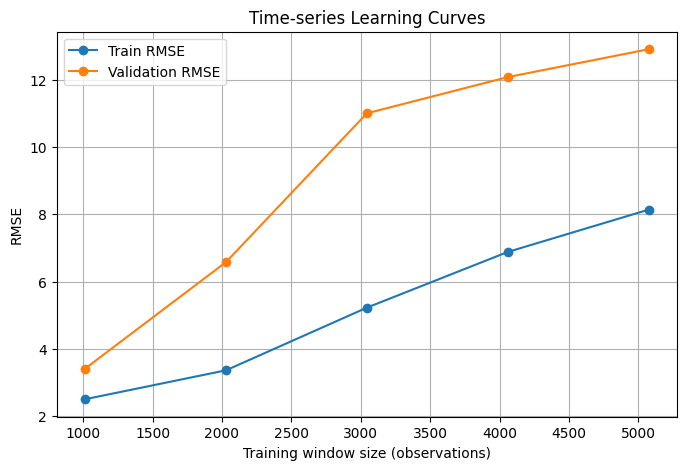

In [503]:
# --- Learning curves ---
if plot_learning_curves:
    # We build curves on TRAIN universe only (to avoid peeking into val)
    train_sizes = np.linspace(int(len(X_train) * 0.2), len(X_train), 5, dtype=int)
    lc_train, lc_val = learning_curves_time_series(pipe, X_train, y_train, train_sizes, n_splits=5, scoring='rmse')
    learning_curves = {"sizes": train_sizes, "train_rmse": lc_train, "val_rmse": lc_val}

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, lc_train, 'o-', label='Train RMSE')
    plt.plot(train_sizes, lc_val, 'o-', label='Validation RMSE')
    plt.xlabel('Training window size (observations)')
    plt.ylabel('RMSE')
    plt.title('Time-series Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

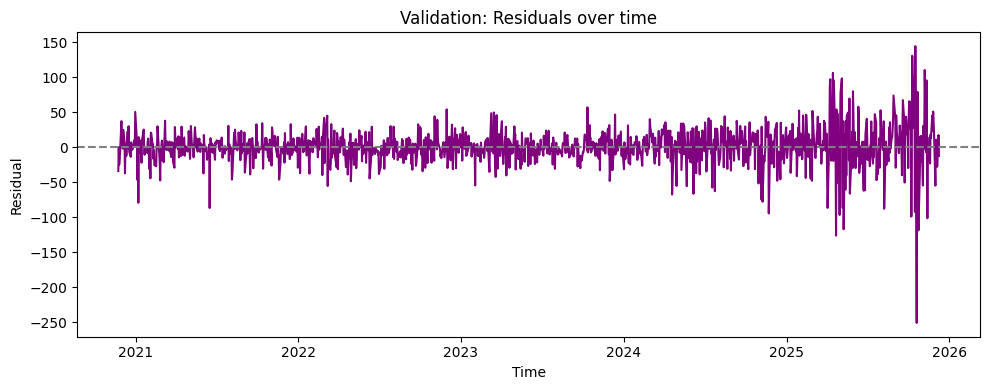

In [504]:
# --- Residuals plot ---
residuals = y_val - y_val_pred

plt.figure(figsize=(10,4))
plt.plot(y_val.index, residuals, color='purple'); plt.axhline(0, color='gray', linestyle='--')
plt.title('Validation: Residuals over time'); plt.xlabel('Time'); plt.ylabel('Residual')
plt.tight_layout(); plt.show()

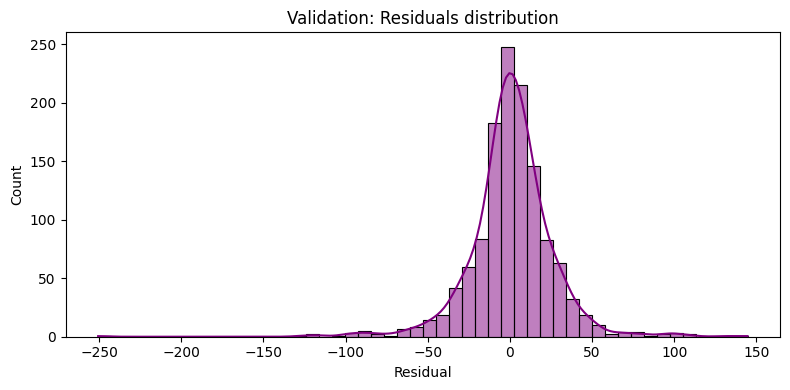

In [505]:
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title('Validation: Residuals distribution'); plt.xlabel('Residual')
plt.tight_layout(); plt.show()

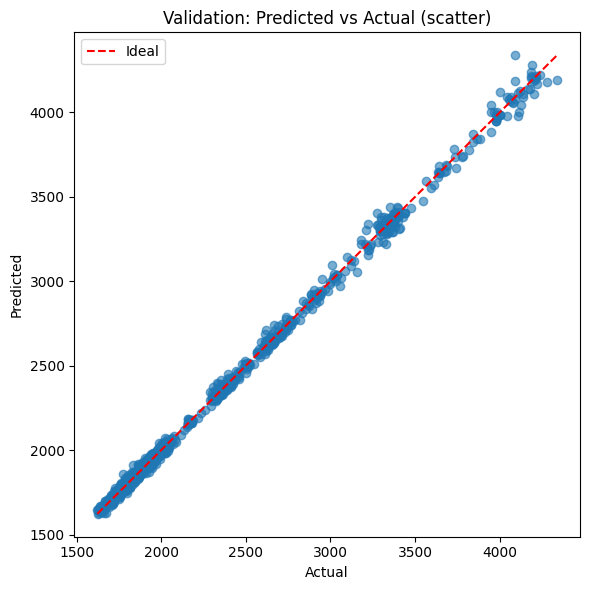

In [506]:
# --- Pred vs actual plots ---
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
lims = [min(y_val.min(), y_val_pred.min()), max(y_val.max(), y_val_pred.max())]
plt.plot(lims, lims, 'r--', label='Ideal')
plt.title('Validation: Predicted vs Actual (scatter)')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.legend(); plt.tight_layout(); plt.show()

In [204]:
y_train = X_train["GC_F_Close"] * (1 + y_train)
y_train_s = pd.Series(y_train, index=y_train.index)
y_val_s = pd.Series(y_val, index=y_val.index)
y_val_pred_s = pd.Series(y_val_pred, index=y_val.index)

df_train = pd.DataFrame({'time': y_train_s.index, 'series': 'Train', 'value': y_train_s.values})
df_actual = pd.DataFrame({'time': y_val_s.index, 'series': 'Actual', 'value': y_val_s.values})
df_pred = pd.DataFrame({'time': y_val_pred_s.index, 'series': 'Predicted', 'value': y_val_pred_s.values})

df_plot = pd.concat([df_train, df_actual, df_pred], axis=0, ignore_index=True)

fig1 = px.line(
    df_plot,
    x='time', y='value', color='series',
    title='Validation: Actual vs Predicted (with Train)',
    labels={'time': 'Time', 'value': 'Target', 'series': 'Series'},
)
fig1.update_layout(template='plotly_white', legend=dict(title=None), title_x=0.5)
fig1.show()

In [111]:
y_val_diff = y_val_s.diff()
y_val_pred_diff = y_val_pred_s.diff()

df_diff_actual = pd.DataFrame({'time': y_val_diff.index, 'series': 'Actual Δ', 'diff': y_val_diff.values})
df_diff_pred   = pd.DataFrame({'time': y_val_pred_diff.index, 'series': 'Predicted Δ', 'diff': y_val_pred_diff.values})

df_diff_plot = pd.concat([df_diff_actual, df_diff_pred], axis=0, ignore_index=True)

fig2 = px.line(
    df_diff_plot,
    x='time', y='diff', color='series',
    title='Validation: Actual vs Predicted Differences (Δ)',
    labels={'time': 'Time', 'diff': 'Difference', 'series': 'Series'},
)
fig2.update_layout(template='plotly_white', legend=dict(title=None), title_x=0.5)
fig2.show()

<Axes: xlabel='GC_F_Close_ret_t+1', ylabel='Count'>

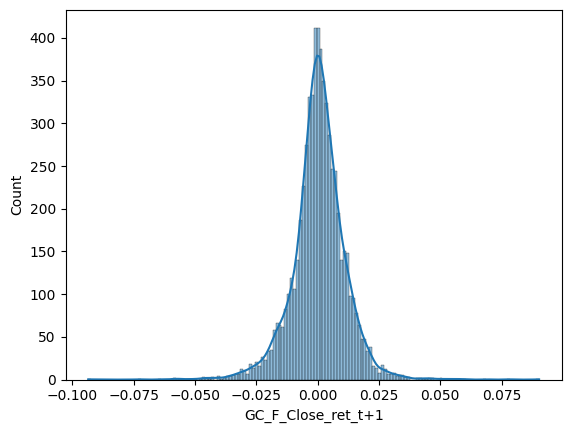

In [ ]:
# --- Target plot ---
y_raw = X['GC_F_Close'].shift(-1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left plot: your original y ---
sns.histplot(y, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Histogram of y")

# --- Right plot: GC_F_Close shifted by -1 ---
sns.histplot(y_raw, kde=True, ax=axes[1], color='green')
axes[1].set_title("Histogram of y_raw")

plt.tight_layout()
plt.show()

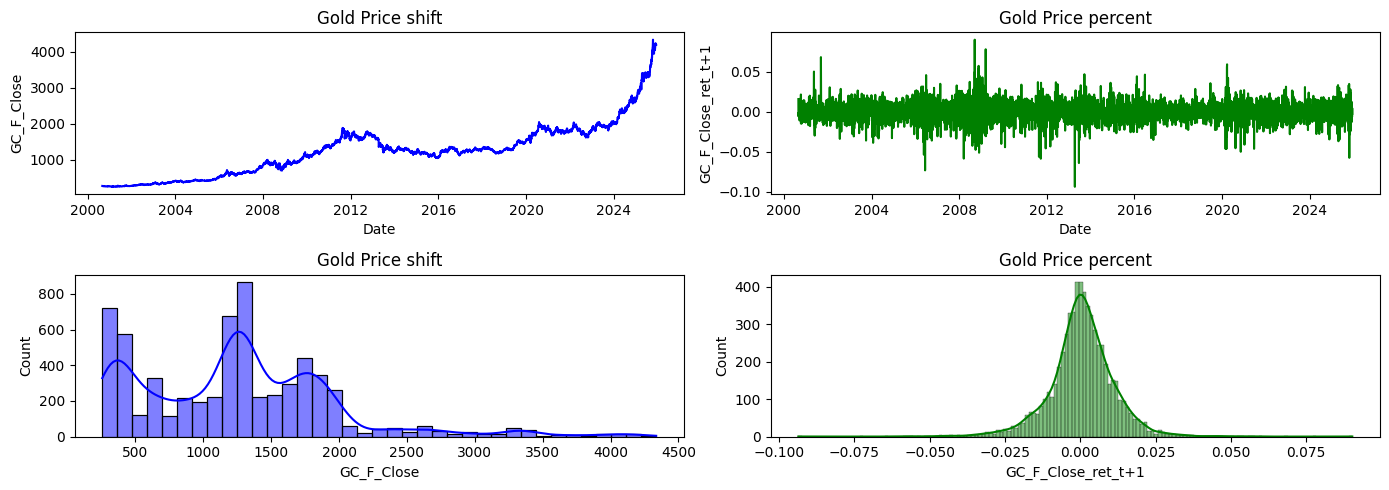

In [34]:
# --- Target plot ---
fig, axes = plt.subplots(2, 2, figsize=(14, 5))

# --- Left plot: your original y ---
sns.lineplot(df['GC_F_Close'].shift(-1), ax=axes[0][0], color='blue')
axes[0][0].set_title("Gold Price shift")

# --- Right plot: GC_F_Close shifted by -1 ---
sns.lineplot(df[target_col], ax=axes[0][1], color='green')
axes[0][1].set_title("Gold Price percent")

# --- Left plot: your original y ---
sns.histplot(df['GC_F_Close'].shift(-1), kde=True, ax=axes[1][0], color='blue')
axes[1][0].set_title("Gold Price shift")

# --- Right plot: GC_F_Close shifted by -1 ---
sns.histplot(df[target_col], kde=True, ax=axes[1][1], color='green')
axes[1][1].set_title("Gold Price percent")

plt.tight_layout()
plt.show()

In [513]:
# --- Fit on full dataset ---
pipe_final = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('filtering', SelectPercentile(score_func=mutual_info_regression, percentile=25)), #50
    ('model', clone(model))
])
pipe_final.fit(X, y)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('pre_custom',
                                                   Pipeline(steps=[('preprocess',
                                                                    PrePreprocessTransformer(exclude=['GC_F_Close'])),
                                                                   ('imputer',
                                                                    CustomPreprocessTransformer()),
                                                                   ('feature',
                                                                    CustomFeatureEngineeringTransformer())])),
                                                  ('ct',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    Pipeline(steps=[('scaler',
                                                                                                     RobustSc...
                                                                                    <function build_preprocessing_pipeline.<locals>.num_except_excluded at 0x7b7d6d15e9e0>),
                                                                                   ('pass',
                                                                                    'passthrough',
                                                                                    ['GC_ret_sign',
                                                                                     'GC_sign_streak'])]))])),
                                 ('corr_feature_dropper',
                                  CustomFeatureSelector())])),
                ('filtering',
                 SelectPercentile(percentile=25,
                                  score_func=<function mutual_info_regression at 0x7b7e5477f400>)),
                ('model', Lasso(alpha=9.446199960520874, max_iter=10000))])

In [ ]:
# --- Save champion pipeline ---
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
champion_path = f"../models/{ts}_champion_v1.pkl"
joblib.dump(pipe_final, champion_path)
print(f"Saved champion pipeline -> {champion_path}")

In [85]:
# ---- Imports ----
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# ---- Configuration ----
TARGET_COL = "GC=F_Close"  # ensure this column exists in df
LOOKBACK = 60              # number of timesteps
TRAIN_RATIO = 0.8         # train/val split
EPOCHS = 40
BATCH_SIZE = 32
CSV_PATH   = "../raw_data/new_data.csv"
DATE_COL = "Date"

# ---- Prepare dataset ----
df = pd.read_csv(CSV_PATH)

other_cols = [c for c in df.columns if c != TARGET_COL]
df = df[[TARGET_COL] + other_cols]

# Ensure datetime and sort chronologically
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.sort_values(DATE_COL).set_index(DATE_COL)

# Drop rows where target is missing
df = df.dropna(subset=[TARGET_COL])

dataset = df[[TARGET_COL]].astype(float).values # we consider only GC_F_Close
training_data_len = int(np.ceil(len(dataset) * TRAIN_RATIO))

# Fit scaler ONLY on train slice to avoid leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset[:training_data_len])
scaled_full = np.empty_like(dataset)
scaled_full[:training_data_len] = scaled_train
scaled_full[training_data_len:] = scaler.transform(dataset[training_data_len:])

# ---- Build sequences helper ----
def build_sequences(series_2d, lookback):
    """
    series_2d: shape (N, 1)
    returns x: (N-lookback, lookback, 1), y: (N-lookback, )
    """
    x, y = [], []
    for i in range(lookback, len(series_2d)):
        x.append(series_2d[i - lookback:i, 0])
        y.append(series_2d[i, 0])
    x = np.array(x)
    y = np.array(y)
    # reshape x to (samples, timesteps, features=1)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    return x, y

# ---- Train set sequences ----
x_train, y_train = build_sequences(scaled_train, LOOKBACK)

# ---- Model ----
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")

# ---- Callbacks ----
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ---- Train ----
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,     # carve validation from training sequences
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

# ---- Test set sequences ----
# We need last LOOKBACK points before training_data_len to seed the first test sequence
test_start = training_data_len - LOOKBACK
test_scaled_slice = scaled_full[test_start:, :]  # includes seed + test
x_test, _ = build_sequences(test_scaled_slice, LOOKBACK)

# Ground truth for test: the raw (unscaled) values starting at training_data_len
y_test = dataset[training_data_len:, 0]  # shape (num_test,)

# ---- Predict ----
pred_scaled = model.predict(x_test)
# inverse_transform expects shape (n,1)
predictions = scaler.inverse_transform(pred_scaled)

# ---- Metrics ----
rmse = root_mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"RMSE score of the model: {rmse:.4f}")
print(f"MAE score of the model: {mae:.4f}")

# ---- Assemble frame for plotting ----
data = df[[TARGET_COL]].copy()

# Split into train/valid by index
train = data.iloc[:training_data_len].copy()
valid = data.iloc[training_data_len:].copy()

# Avoid SettingWithCopyWarning:
valid = valid.assign(Predictions=predictions)

# ---- Plot ----
# plt.figure(figsize=(16, 6))
# plt.title('LSTM Model — Gold Close Price Forecast', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Close Price USD ($)', fontsize=12)

# plt.plot(train.index, train[TARGET_COL], label='Train', color='tab:blue')
# plt.plot(valid.index, valid[TARGET_COL], label='Val (Actual)', color='tab:orange')
# plt.plot(valid.index, valid['Predictions'], label='Predictions', color='tab:green')

# plt.legend(loc='lower right')
# plt.grid(True, alpha=0.2)
# plt.tight_layout()
# plt.show()

import plotly.express as px

# Combine train and valid into one DataFrame for easy plotting
train['Type'] = 'Train'
valid['Type'] = 'Val (Actual)'
valid_pred = valid.copy()
valid_pred['Type'] = 'Predictions'
valid_pred[TARGET_COL] = valid_pred['Predictions']

df_plot = pd.concat([train, valid, valid_pred])

fig = px.line(
    df_plot,
    x=df_plot.index,
    y=TARGET_COL,
    color='Type',
    title='LSTM Model — Gold Close Price Forecast',
    labels={'x': 'Date', TARGET_COL: 'Close Price USD ($)'},
    template='plotly_white'
)

fig.update_layout(width=1000, height=400)

Epoch 1/40


/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



142/142 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - loss: 4.8540e-04 - val_loss: 0.0213
Epoch 2/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - loss: 0.0060 - val_loss: 0.0319
Epoch 3/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - loss: 0.0082 - val_loss: 0.0254
Epoch 4/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - loss: 0.0165 - val_loss: 0.0275
Epoch 5/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0161 - val_loss: 0.0302
Epoch 6/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.0184 - val_loss: 0.0217
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
RMSE score of the model: 735.8528
MAE score of the model: 624.6304


/home/theo/.pyenv/versions/Forecasting-Gold-Price/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - loss: 0.0266 - val_loss: 0.0154
Epoch 2/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - loss: 3.5225e-04 - val_loss: 0.0160
Epoch 3/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - loss: 2.8022e-04 - val_loss: 0.0155
Epoch 4/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 2.4498e-04 - val_loss: 0.0125
Epoch 5/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - loss: 2.3338e-04 - val_loss: 0.0127
Epoch 6/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - loss: 2.4426e-04 - val_loss: 0.0128
Epoch 7/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - loss: 2.6759e-04 - val_loss: 0.0124
Epoch 8/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - loss: 2.3630e-04 - val_loss: 0.0081
Epoch 9/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 2.5822e-04 - val_loss: 0.0115
Epoch 10/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 2.5197e-04 - val_loss: 0.0069
Epoch 11/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - loss: 2.2349e-04 - val_los

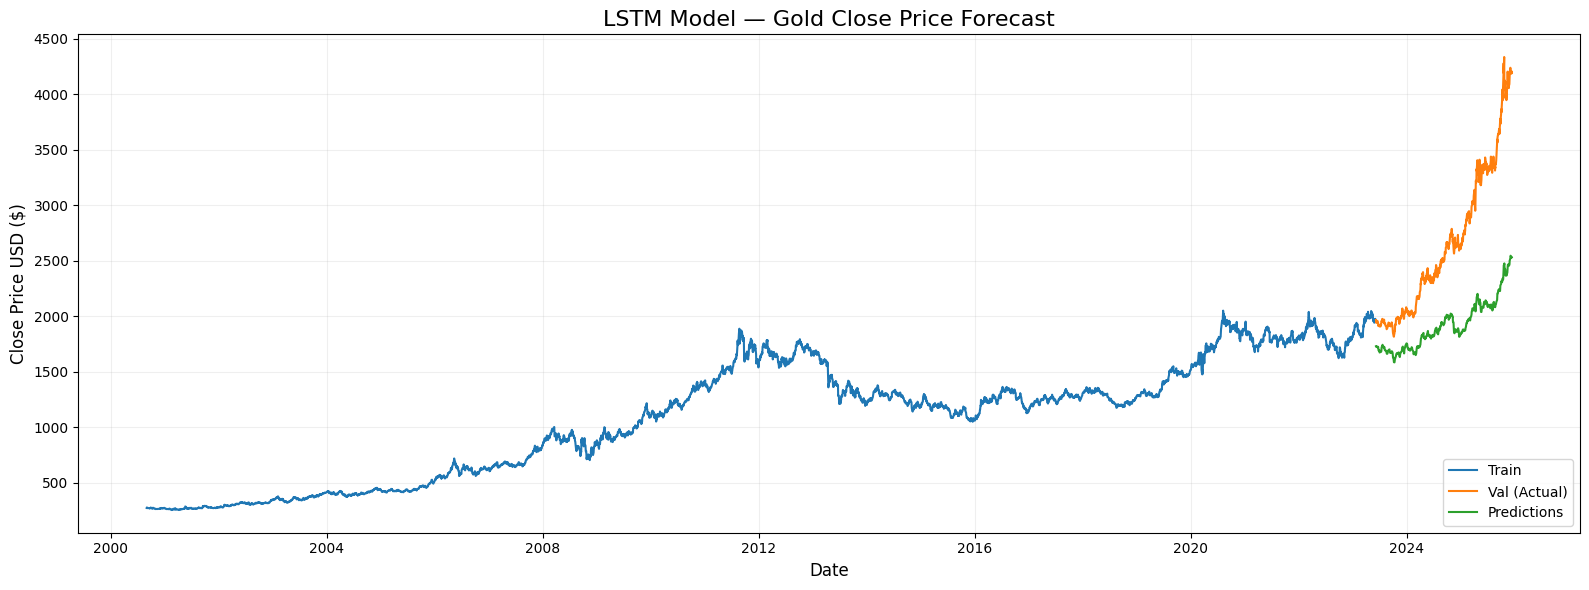

In [86]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# ---- Load & Prepare ----
FEATURE_COLS = df.columns.tolist()
#FEATURE_COLS = [col for col in df.columns if col.endswith('_Close')]

TARGET_COL = "GC=F_Close"  # ensure this column exists in df
LOOKBACK = 60              # number of timesteps
TRAIN_RATIO = 0.9         # train/val split
EPOCHS = 40
BATCH_SIZE = 32
CSV_PATH   = "../raw_data/new_data.csv"
DATE_COL = "Date"

# Convert to numpy
df = pd.read_csv(CSV_PATH)

# Ensure datetime and sort chronologically
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.sort_values(DATE_COL).set_index(DATE_COL)

# Drop rows where target is missing
df = df.dropna(subset=[TARGET_COL])

df = df[FEATURE_COLS].copy().ffill().bfill()
dataset = df[FEATURE_COLS].astype(float).values
training_data_len = int(np.ceil(len(dataset) * TRAIN_RATIO))

# ---- Scale features ----
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset[:training_data_len])
scaled_full = np.empty_like(dataset)
scaled_full[:training_data_len] = scaled_train
scaled_full[training_data_len:] = scaler.transform(dataset[training_data_len:])

# ---- Build sequences for multivariate ----
def build_sequences_multivariate(series_2d, lookback):
    x, y = [], []
    for i in range(lookback, len(series_2d)):
        x.append(series_2d[i - lookback:i])  # shape (lookback, num_features)
        y.append(series_2d[i, 0])  # predict first column (gold price)
    return np.array(x), np.array(y)

x_train, y_train = build_sequences_multivariate(scaled_train, LOOKBACK)

# ---- Model ----
num_features = len(FEATURE_COLS)
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(LOOKBACK, num_features)),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

# ---- Train ----
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

# ---- Test ----
test_start = training_data_len - LOOKBACK
x_test, _ = build_sequences_multivariate(scaled_full[test_start:], LOOKBACK)
y_test = dataset[training_data_len:, 7]

pred_scaled = model.predict(x_test)
predictions = scaler.inverse_transform(
    np.concatenate([pred_scaled, np.zeros((len(pred_scaled), num_features - 1))], axis=1)
)[:, 0]  # inverse only first column

# ---- Metrics ----
rmse = root_mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"RMSE score of the model: {rmse:.4f}")
print(f"MAE score of the model: {mae:.4f}")

# ---- Assemble frame for plotting ----
data = df[[TARGET_COL]].copy()

# Split into train/valid by index
train = data.iloc[:training_data_len].copy()
valid = data.iloc[training_data_len:].copy()

# Avoid SettingWithCopyWarning:
valid = valid.assign(Predictions=predictions)

# ---- Plot ----
plt.figure(figsize=(16, 6))
plt.title('LSTM Model — Gold Close Price Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)

plt.plot(train.index, train[TARGET_COL], label='Train', color='tab:blue')
plt.plot(valid.index, valid[TARGET_COL], label='Val (Actual)', color='tab:orange')
plt.plot(valid.index, valid['Predictions'], label='Predictions', color='tab:green')

plt.legend(loc='lower right')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

Train seq shape: (4380, 60, 118), Val: (891, 60, 118), Test: (892, 60, 118)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 60, 118)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 60, 512)        │     1,292,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 60, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,333,057 (8.90 MB)

 Trainable params: 2,333,057 (8.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - loss: 478313.0938 - mae: 573.7777
Epoch 1: val_loss improved from inf to 2376686.50000, saving model to best_lstm_gold.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 72s 937ms/step - loss: 486062.1250 - mae: 578.5736 - val_loss: 2376686.5000 - val_mae: 1522.6136 - learning_rate: 0.0010
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - loss: 269388.4375 - mae: 412.1707
Epoch 2: val_loss improved from 2376686.50000 to 730823.50000, saving model to best_lstm_gold.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 60s 872ms/step - loss: 272914.3750 - mae: 415.2522 - val_loss: 730823.5000 - val_mae: 820.0540 - learning_rate: 0.0010
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - loss: 223339.0312 - mae: 427.8586
Epoch 3: val_loss improved from 730823.50000 to 252434.39062, saving model to best_lstm_gold.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 68s 992ms/step - loss: 223225.2344 - mae: 427.3015 - val_loss: 252434.3906 - val_mae: 440.5672 - learning_rate: 0.0010
Epoch 

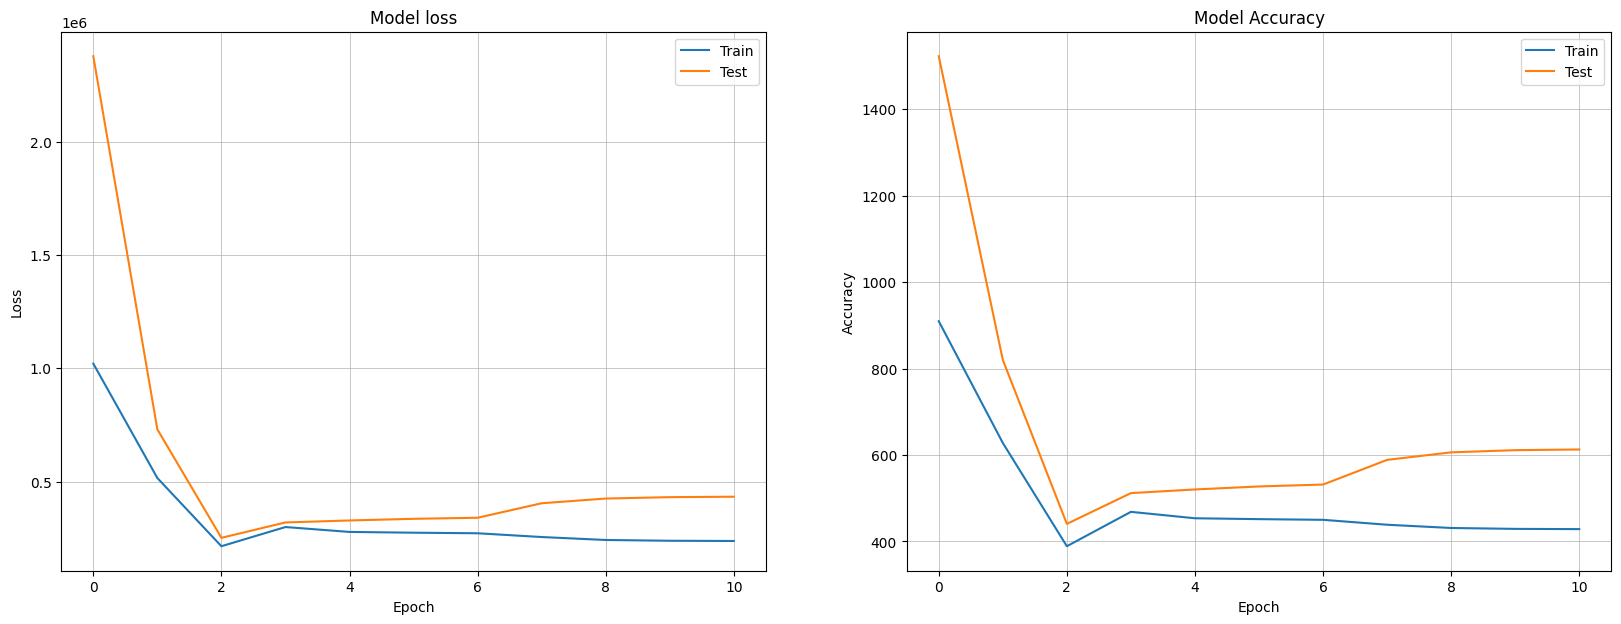

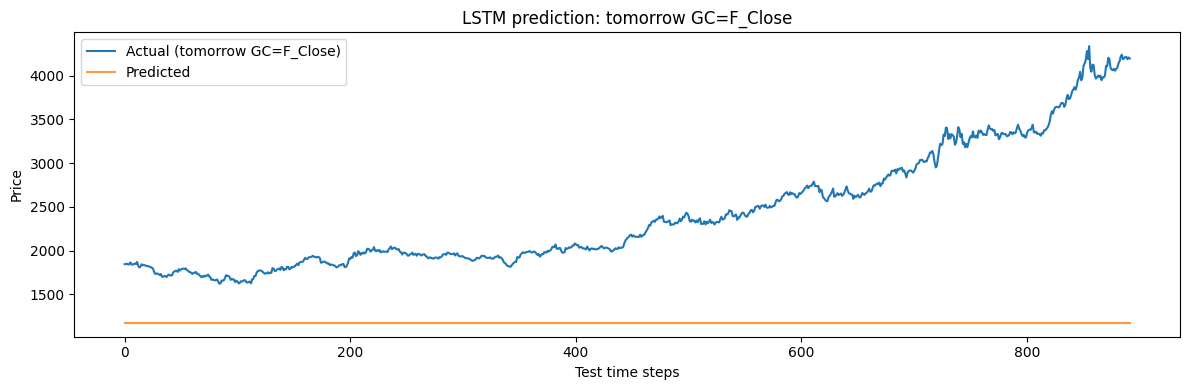

In [88]:
# Feature selection: try SHAP/permutation importance on a simpler model first
# (e.g., LightGBM) to reduce noise, then feed selected features to LSTM.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras import layers, callbacks, models

# ---------------------
# Configurable parameters
# ---------------------
CSV_PATH   = "../raw_data/new_data.csv"     # path to your uploaded file
TARGET_COL = "GC=F_Close"        # predict tomorrow's close for gold futures
DATE_COL   = "Date"
LOOKBACK   = 60                  # number of past days in each sequence
BATCH_SIZE = 64
EPOCHS     = 50
VAL_PATIENCE = 8                 # early stopping patience
LR_REDUCE_PATIENCE = 4
LAGS = [1, 5, 10, 20]

# ---------------------
# 1) Load & basic cleaning
# ---------------------
df = pd.read_csv(CSV_PATH)

# Ensure datetime and sort chronologically
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.sort_values(DATE_COL).set_index(DATE_COL)

# Drop rows where target is missing
df = df.dropna(subset=[TARGET_COL])

# Create tomorrow's target by shifting -1 (next day)
df["target_tomorrow"] = df[TARGET_COL].shift(-1)

# After shift, last row has NaN target; drop it
df = df.dropna(subset=["target_tomorrow"]).reset_index(drop=True)

# Lag features: add past values of the target as exogenous inputs
for lag in LAGS:
    df[f"{TARGET_COL}_lag{lag}"] = df[TARGET_COL].shift(lag)

# ---------------------
# 2) Feature selection & imputation
# ---------------------
# Inputs = all columns except DATE_COL and TARGET_COL; exclude helper columns too
exclude = {DATE_COL, TARGET_COL, "target_tomorrow"}
feature_cols = [c for c in df.columns if c not in exclude]

# Time-series friendly imputation: forward-fill then back-fill
X_raw = df[feature_cols].copy().ffill().bfill()

# Target vector
y_raw = df["target_tomorrow"].values.astype(np.float32)

# ---------------------
# 3) Chronological split: train / val / test
# ---------------------
n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

X_train_raw = X_raw.iloc[:train_end].copy()
X_val_raw   = X_raw.iloc[train_end:val_end].copy()
X_test_raw  = X_raw.iloc[val_end:].copy()

y_train = y_raw[:train_end]
y_val   = y_raw[train_end:val_end]
y_test  = y_raw[val_end:]

# ---------------------
# 4) Scale features (fit on train only)
# ---------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled   = scaler.transform(X_val_raw)
X_test_scaled  = scaler.transform(X_test_raw)

n_features = X_train_scaled.shape[1]

# ---------------------
# 5) Build rolling windows (LSTM sequences)
# ---------------------
def make_sequences(X, y, lookback):
    """
    Build sequences of shape (num_samples, lookback, num_features) and aligned targets.
    Each sequence uses X[t-lookback:t] to predict y[t].
    """
    X_seq, y_seq = [], []
    for t in range(lookback, len(X)):
        X_seq.append(X[t - lookback:t])
        y_seq.append(y[t])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32)

X_tr_seq, y_tr_seq = make_sequences(X_train_scaled, y_train, LOOKBACK)
X_va_seq, y_va_seq = make_sequences(X_val_scaled,   y_val,   LOOKBACK)
X_te_seq, y_te_seq = make_sequences(X_test_scaled,  y_test,  LOOKBACK)

print(f"Train seq shape: {X_tr_seq.shape}, Val: {X_va_seq.shape}, Test: {X_te_seq.shape}")

# ---------------------
# 6) Define the LSTM model
# ---------------------
def build_model(n_features, lookback):
    inputs = layers.Input(shape=(lookback, n_features))
    x = layers.LSTM(512, return_sequences=True)(inputs)
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    #x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    #x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])
    return model

model = build_model(n_features, LOOKBACK)
model.summary()

# ---------------------
# 7) Callbacks
# ---------------------
ckpt_path = "best_lstm_gold.keras"
cbs = [
    callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=VAL_PATIENCE, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", patience=LR_REDUCE_PATIENCE, factor=0.5, min_lr=1e-5, verbose=1),
]

# ---------------------
# 8) Train
# ---------------------
history = model.fit(
    X_tr_seq, y_tr_seq,
    validation_data=(X_va_seq, y_va_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,        # important for time series
    callbacks=cbs,
    verbose=1
)

def plot_loss_accuracy(history):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    #ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    #ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return fig

plot_loss_accuracy(history)

# ---------------------
# 9) Evaluate on test
# ---------------------
y_pred_test = model.predict(X_te_seq).squeeze()

mae  = mean_absolute_error(y_te_seq, y_pred_test)
rmse = sqrt(mean_squared_error(y_te_seq, y_pred_test))

def mape(a, f):
    return np.mean(np.abs((a - f) / np.clip(np.abs(a), 1e-8, None))) * 100

mape_val = mape(y_te_seq, y_pred_test)

print(f"Test MAE:  {mae:,.4f}")
print(f"Test RMSE: {rmse:,.4f}")
print(f"Test MAPE: {mape_val:,.2f}%")

# ---------------------
# 10) Plot predictions vs actual
# ---------------------
plt.figure(figsize=(12,4))
plt.plot(y_te_seq, label="Actual (tomorrow GC=F_Close)")
plt.plot(y_pred_test, label="Predicted", alpha=0.8)
plt.title("LSTM prediction: tomorrow GC=F_Close")
plt.xlabel("Test time steps")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig("lstm_gold_test_plot.png", dpi=140)

# ---------------------
# 11) Save predictions and scaler
# ---------------------
# pd.DataFrame({
#     "y_true": y_te_seq,
#     "y_pred": y_pred_test
# }).to_csv("lstm_gold_test_predictions.csv", index=False)

# # Save scaler for inference consistency
# import joblib
# joblib.dump(scaler, "feature_scaler.pkl")

# print("Artifacts saved: best_lstm_gold.keras, lstm_gold_test_plot.png, lstm_gold_test_predictions.csv, feature_scaler.pkl")


In [ ]:
LOOKBACK = 60
scaler = joblib.load("feature_scaler.pkl")
model  = tf.keras.models.load_model("best_lstm_gold.keras")

# Prepare the latest LOOKBACK rows of features (same columns / order as during training):
latest_df = pd.read_csv("new_data.csv").sort_values("Date")
exclude   = {"Date", "GC=F_Close", "target_tomorrow"}
feature_cols = [c for c in latest_df.columns if c not in exclude]
X_latest = latest_df[feature_cols].ffill().bfill().values

X_latest_scaled = scaler.transform(X_latest)
X_input = np.asarray([X_latest_scaled[-LOOKBACK:]], dtype=np.float32)  # shape (1, LOOKBACK, n_features)

pred_next = model.predict(X_input)[0,0]
print("Predicted GC=F_Close for tomorrow:", pred_next)

In [83]:
# --- Extract article ---
# ✅ Direct Gold-Related Topics
# These directly mention gold and its market:
# "gold price", "gold futures", "gold spot", "gold market", "gold demand", "gold supply"
# "gold ETF", "gold reserves", "gold mining"
# "gold volatility", "gold technical analysis"

# ✅ Exogenous Factors (Indirect but Highly Influential)
# Gold is a safe-haven asset, so its price reacts to global uncertainty and macroeconomic signals. Include these topics:
# 1. Monetary Policy & Interest Rates
# "Federal Reserve", "Fed rate hike", "interest rates", "monetary policy", "ECB policy"
# "inflation", "CPI", "PPI"

# 2. Currency Movements
# "US dollar index", "USD strength", "currency fluctuations"
# "forex market", "dollar appreciation"

# 3. Geopolitical Risks
# "geopolitical tensions", "war", "conflict", "Middle East crisis", "Russia sanctions"
# "trade war", "China-US relations"

# 4. Economic Indicators
# "GDP growth", "recession fears", "economic slowdown"
# "unemployment rate", "job data"

# 5. Commodity & Energy Prices
# "oil price", "crude oil", "commodity market"
# "energy crisis"

# 6. Market Sentiment
# "stock market crash", "equity volatility", "VIX index"
# "safe haven demand", "risk-off sentiment"

# ✅ Why These Matter

# Gold vs USD: Gold is priced in USD, so a strong dollar usually means weaker gold.
# Interest Rates: Higher rates make gold less attractive (no yield).
# Inflation & Crisis: Gold is a hedge against inflation and uncertainty.
# Geopolitical Events: Wars and crises often boost gold demand.

# ✅ Next Steps

# Use these keywords in your Yahoo Finance article extraction.
# Apply sentiment analysis (e.g., VADER, FinBERT) to classify articles as positive/negative for gold.
# Combine sentiment score with historical gold price features (technical indicators like moving averages, RSI).

search = yf.Search("Tesla", news_count=30)

for article in search.news:
    print("Titre :", article["title"])
    print("Source :", article["publisher"])
    print("Lien :", article["link"])

    url = article["link"]
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")

        # Exemple : extraire le texte principal
        paragraphs = soup.find_all("p")
        content = " ".join([p.get_text() for p in paragraphs])

        print("Contenu extrait :", content)
    else:
        print("Impossible de récupérer l'article :", response.status_code)

    print("===")

DNSError: Failed to perform, curl: (6) Could not resolve host: query2.finance.yahoo.com. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

In [ ]:
# After loading & sorting df (market data)
# 1) Merge sentiment
df_sent = pd.read_parquet("df_sent_daily.parquet")
df_sent["Date"] = pd.to_datetime(df_sent["Date"])
df_sent = df_sent.sort_values("Date")
sent_cols = [c for c in df_sent.columns if c != "Date"]
df_sent[sent_cols] = df_sent[sent_cols].fillna(0.0)

df = df.sort_values(DATE_COL)
df_merged = pd.merge(df, df_sent, on="Date", how="left")
df_merged[sent_cols] = df_merged[sent_cols].fillna(0.0)

# 2) Lags/rolls
base_sent = [c for c in [
    "finbert_signed_mean","finbert_signed_median","finbert_signed_std",
    "finbert_pos_mean","finbert_neg_mean",
    "n_articles","n_domains",
    "gold_share","rates_share","usd_share","geopol_share",
    "macro_share","energy_share","sentiment_mkt_share","any_gold_related_share"
] if c in df_merged.columns]

for c in base_sent:
    df_merged[f"{c}_lag1"] = df_merged[c].shift(1)
    df_merged[f"{c}_lag2"] = df_merged[c].shift(2)
    df_merged[f"{c}_lag3"] = df_merged[c].shift(3)
    df_merged[f"{c}_roll3"] = df_merged[c].shift(1).rolling(3).mean()
    df_merged[f"{c}_roll7"] = df_merged[c].shift(1).rolling(7).mean()

df_merged = df_merged.drop(columns=base_sent)  # keep only lag/roll versions

# 3) Target & features
df_merged["target_tomorrow"] = df_merged[TARGET_COL].shift(-1)
df_merged = df_merged.dropna(subset=["target_tomorrow"]).reset_index(drop=True)

exclude = {DATE_COL, TARGET_COL, "target_tomorrow"}
feature_cols = [c for c in df_merged.columns if c not in exclude]

X_raw = df_merged[feature_cols].copy().ffill().bfill()
y_raw = df_merged["target_tomorrow"].values.astype(np.float32)

# 4) Keep the rest of your pipeline identical (split → scale → sequences → model)
